# Predicting Medical Appointment No Shows

## Problem Statement
A person makes a doctor appointment, receives all the instructions and no-show. Who to blame?
Our client is a medical ERP solutions provider, who wants to address this no-show issue by building an ML model that will be able to predict whether a patient will be a show or no-show.
The objective is to build the model and incorporate it into their ERP software which will then be used by their customers to better manage their appointments. 

## Data Description
Below is a table that summarizes the data dictionary:

| No | Column Name      | Description                                                                                                           |
|----|------------------|-----------------------------------------------------------------------------------------------------------------------|
| 01 | PatientId        | Identification of a patient                                                                                           |
| 02 | AppointmentID    | Identification of each appointment                                                                                    |
| 03 | Gender           | Male or Female. Female is the greater proportion, women take way more care of their health in comparison to men.      |
| 04 | ScheduledDay     | The day someone called or registered the appointment, this is before the appointment of course.                       |
| 05 | AppointmentDay   | The day of the actual appointment, when they have to visit the doctor.                                                |
| 06 | Age              | How old is the patient.                                                                                               |
| 07 | Neighbourhood    | Where the appointment takes place.                                                                                    |
| 08 | Scholarship      | True or False. Indicates whether the patient is enrolled in Brasilian welfare program Bolsa Família.                  |
| 09 | Hypertension     | True or False. Indicates if the patient has hypertension.                                                             |
| 10 | Diabetes         | True or False. Indicates if the patient has diabetes.                                                                 |
| 11 | Alcoholism       | True or False. Indicates if the patient is an alcoholic.                                                              |
| 12 | Handcap          | True or False. Indicates if the patient is handicapped.                                                               |
| 13 | SMS_received     | True or False. Indicates if 1 or more messages sent to the patient.                                                   |
| 14 | No-show          | True or False (**Target variable**). Indicates if the patient missed their appointment.                               |

The dataset used for this project can be downloaded from [Kaggle](https://www.kaggle.com/datasets/joniarroba/noshowappointments).

## Modules Importation
Below are the modules required to run this notebook, some modules will need to be installed explicitly.

In [1]:
%%capture

# Use src/requirements.txt to install necessary packages, instead of below individual pip install commands
# 1) conda create --name medical_app_env python=3.10 -y
# 2) cd src
# 3) pip install -r requirements.txt

# !pip install snowflake-connector-python
# !pip install snowflake-sqlalchemy
# !pip install category_encoders
# !pip install hyperopt
# !pip install imblearn
# !pip install xgboost

In [2]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, pointbiserialr

### SKLearn Imports ###
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc, roc_auc_score, ConfusionMatrixDisplay,f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


from category_encoders import TargetEncoder
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import sqlalchemy
import snowflake.connector
from sqlalchemy import create_engine
from snowflake.sqlalchemy import *
import src.snowflake_creds as snowflake_creds

import warnings
warnings.filterwarnings('ignore')

d:\Softwares\anaconda3\envs\setup_project_env\lib\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Data Loading from Snowflake
The downloaded dataset (Medical-Appointment-No-Show-Prediction\data\main\full-data\KaggleV2-May-2016.csv) from kaggle was first loaded to a Snowflake database for storage ([reference for loading data to Snowflake](https://www.chaosgenius.io/blog/snowflake-upload-csv/)). With utilizing SQL queries (Snowflake_assets\Create APPOINTMENT_DATA table.sql), a hypothesis based Exploratory Data Analysis was performed to test our assumptions (Snowflake_assets\Hypothesis based EDA.sql).

For this notebook, We're going to connect to the Snowflake database using [Snowflake SQLAlchemy](https://docs.snowflake.com/en/developer-guide/python-connector/sqlalchemy#:~:text=can%20use%20the-,snowflake.sqlalchemy.URL,-method%20to%20constructhttps://docs.snowflake.com/en/developer-guide/python-connector/sqlalchemy#:~:text=can%20use%20the-,snowflake.sqlalchemy.URL,-method%20to%20construct), execute a SQL query to retrieve the appointment data, and load the returned result into a Pandas DataFrame.

In [3]:
# # Define the Snowflake connection parameters
# # Sagemaker
# '''
# Note: Account info can be obtained from
# full URL (https://{account info}.snowflakecomputing.com) of the Snowflake account
# '''
# engine = create_engine(URL(
#         account="lvb79593.us-east-1",
#         user= snowflake_creds.USER_NAME,
#         password= snowflake_creds.PASSWORD,
#         role="ACCOUNTADMIN",
#         warehouse="MY_WAREHOUSE",
#         database="MEDICAL_APPOINTMENT_NO_SHOW",
#         schema="APPOINTMENT_SCHEMA"
#     ))

# # Define the SQL query that retrieves the appointment data
# '''
# Note: Specify database and schema where table is stored under
# '''
# query = """
# SELECT * FROM MEDICAL_APPOINTMENT_NO_SHOW.APPOINTMENT_SCHEMA.APPOINTMENT_DATA;
# """

# # Use a context manager to ensure the connection is closed after executing the query
# try:
#     with engine.connect() as conn:
#         # Execute the query and load the result into a Pandas DataFrame
#         data = pd.DataFrame(pd.read_sql(query, conn))
#         # Convert column names to uppercase
#         data.columns = [col.upper() for col in data.columns.tolist()]
#         # Print connection successful message
#         print("Connection successful. Data loaded into DataFrame.")
        
# except Exception as e:  # Catch any exceptions that occur
#     print(f"An error occurred: {e}")

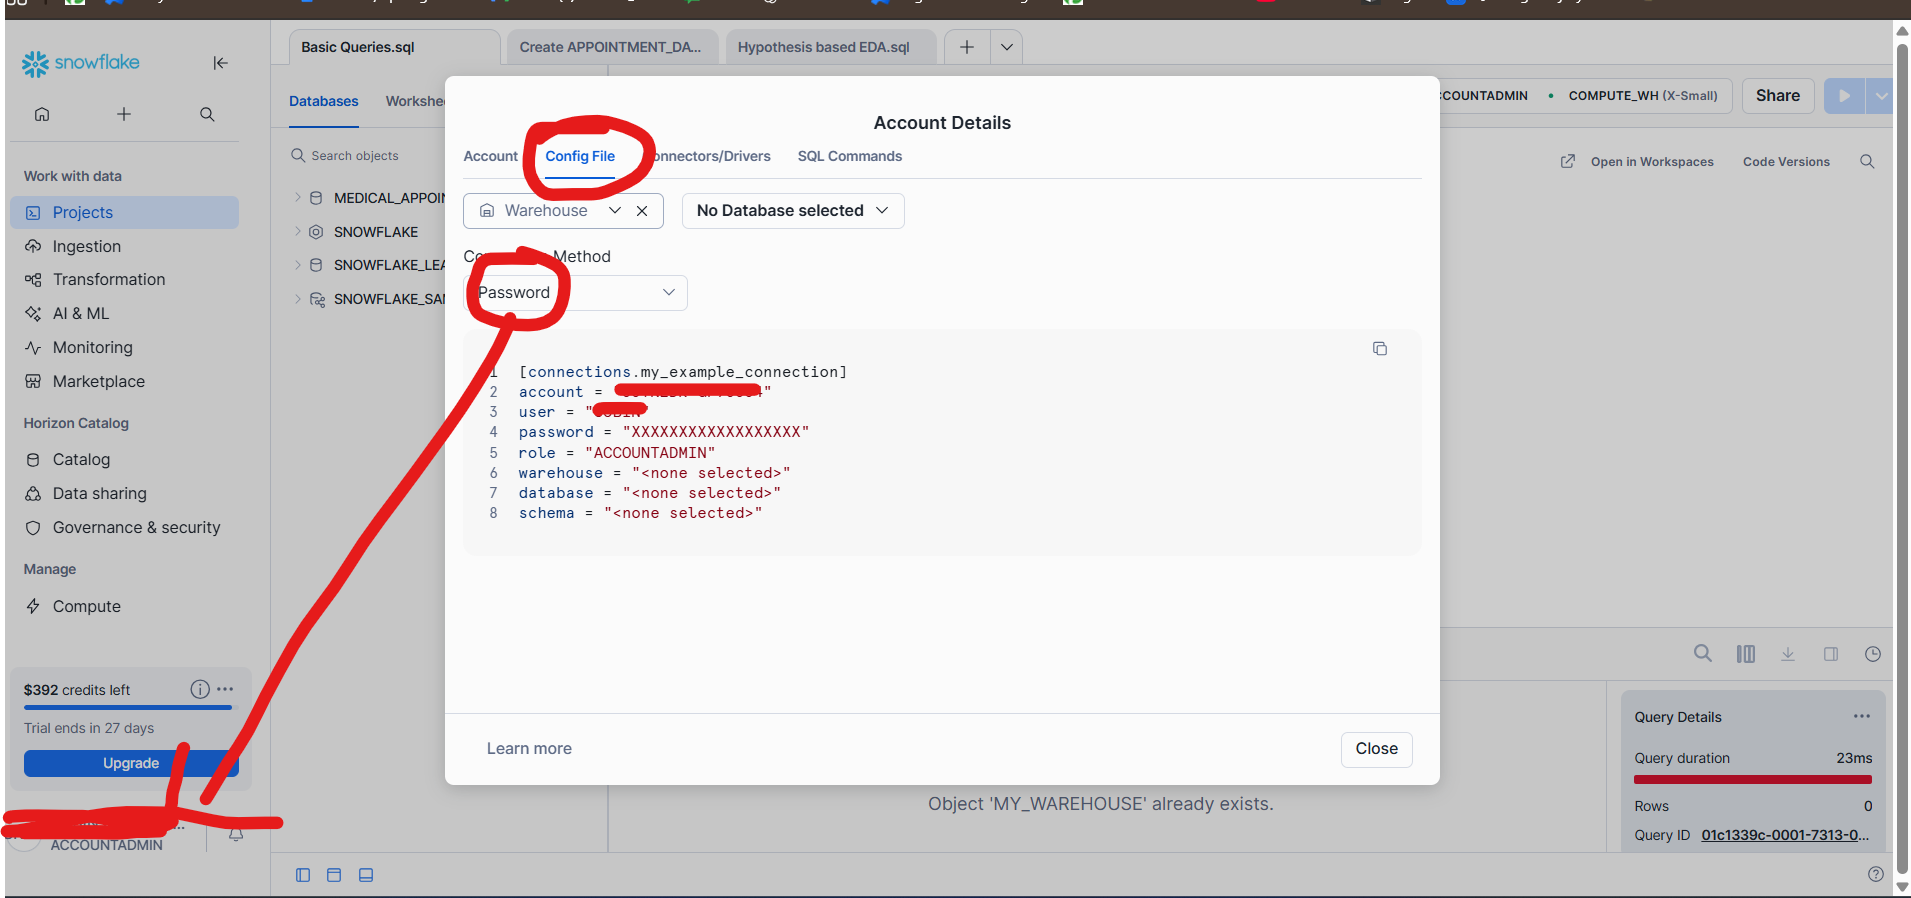

In [4]:
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
import os
snowflake_user = os.getenv("SNOWFLAKE_USER")
snowflake_password = os.getenv("SNOWFLAKE_PASSWORD")
snowflake_account = os.getenv("SNOWFLAKE_ACCOUNT")
snowflake_role = os.getenv("SNOWFLAKE_ROLE")
snowflake_warehouse = os.getenv("SNOWFLAKE_WAREHOUSE")
snowflake_database = os.getenv("SNOWFLAKE_DATABASE")
snowflake_schema = os.getenv("SNOWFLAKE_SCHEMA")

In [6]:
# Define the Snowflake connection parameters
# Initial Code
'''
Note: Account info can be obtained from
full URL (https://{account info}.snowflakecomputing.com) of the Snowflake account
'''
engine = create_engine(URL(
        account=snowflake_account,
        user= snowflake_user,
        password= snowflake_password,
        role=snowflake_role,
        warehouse=snowflake_warehouse,
        database=snowflake_database,
        schema=snowflake_schema
    ))

# Define the SQL query that retrieves the appointment data
'''
Note: Specify database and schema where table is stored under
'''
query = """
SELECT * FROM MEDICAL_APPOINTMENT_NO_SHOW.APPOINTMENT_SCHEMA.APPOINTMENT_DATA;
"""

# Use a context manager to ensure the connection is closed after executing the query
try:
    with engine.connect() as conn:
        # Execute the query and load the result into a Pandas DataFrame
        data = pd.DataFrame(pd.read_sql(query, conn))
        # Convert column names to uppercase
        data.columns = [col.upper() for col in data.columns.tolist()]
        # Print connection successful message
        print("Connection successful. Data loaded into DataFrame.")
        
except Exception as e:  # Catch any exceptions that occur
    print(f"An error occurred: {e}")

Connection successful. Data loaded into DataFrame.


Optionally, we can save the data frame to our local disk for ease to load them back into our workspace for analysis. (Nobody train a ML model in one sit, they close the laptop and come back, so loading the data from snowflake is a time consuming task, so we save them to a pickle file and the loading is fast)
```python
# Save DataFrame to a pickle file
data.to_pickle("./data/input/full_data.pkl")
```

#### Sampling from the raw, unprocessed data (data\main\full-data\KaggleV2-May-2016.csv) to create a simulated set to mimic the real-world scenario where we receive new data without labels and need to make predictions   

#### We take a random sample from our original data (data\main\full-data\KaggleV2-May-2016.csv) and pretend it’s new, unseen data—just like what we’d get in real life when we want to make predictions. To make it realistic, we remove the answers (labels) from this sample, so our model doesn’t “cheat” by seeing the correct results. This helps us test how well our prediction process works on data where we don’t know the outcome yet.  

#### You are taking a portion of your original, unprocessed dataset (data\main\full-data\KaggleV2-May-2016.csv) and setting aside some rows as a "simulated set." In this set, you remove the target labels (set them to NaN), so it looks like new, unseen data you might get in the real world—where you don’t know the true outcomes yet. This allows you to test your prediction pipeline as if you were making predictions on real, unlabeled data.  

#### QN : Is the simulated set training data?
#### ANS: No, the simulated set is not training data. It is a separate sample taken from your original data, with the target labels removed, to mimic new, real-world data where you don’t know the outcomes. You use it to test your prediction pipeline, not to train your model.

#### Is this rows included in training dataset?
#### No, the rows in the simulated set are not included in the training dataset. They are separated out from the original data before training, so your model does not see them during training. This helps you test your model on truly unseen data, just like in a real-world prediction scenario.

```python
# Split the data to maintain the distribution of the target variable
_, simulated_set = train_test_split(
    data, 
    test_size=0.2, 
    stratify=data['NO_SHOW'],  # Stratify based on the target variable
    random_state=42
)

# Set the targets to NaN
simulated_set['NO_SHOW'] = np.nan

# Save the simulated set to a CSV file
simulated_set.to_csv('./data/input/simulated_set.csv', index=False)

print("Stratified simulated set saved to './data/input/simulated_set.csv'")
```

#### In the above code we think if we give data as a parameter to train_test_split it would return 4 variables but train_test_split returns 2 outputs if you pass it 1 object, and 4 outputs if you pass it 2 objects (X and y separately).

#### returns two DataFrames:

* the first output = the remaining 80% (train part)
* the second output = the 20% sample you called simulated_set
* _ is just a Python convention meaning: “I’m intentionally ignoring this returned value.”
So here, _ is the 80% portion that you don’t store.

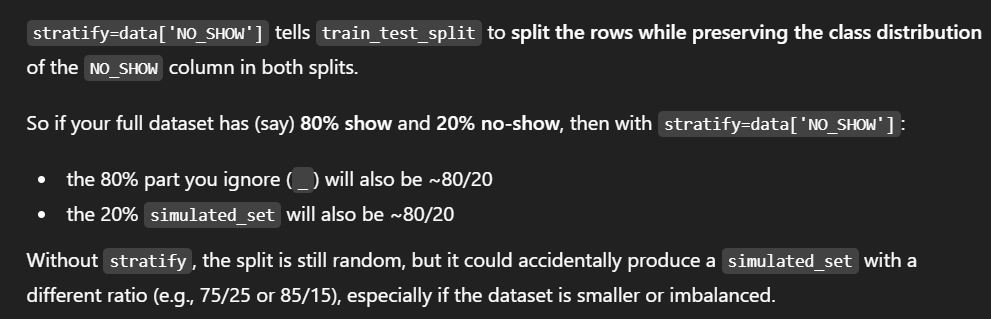

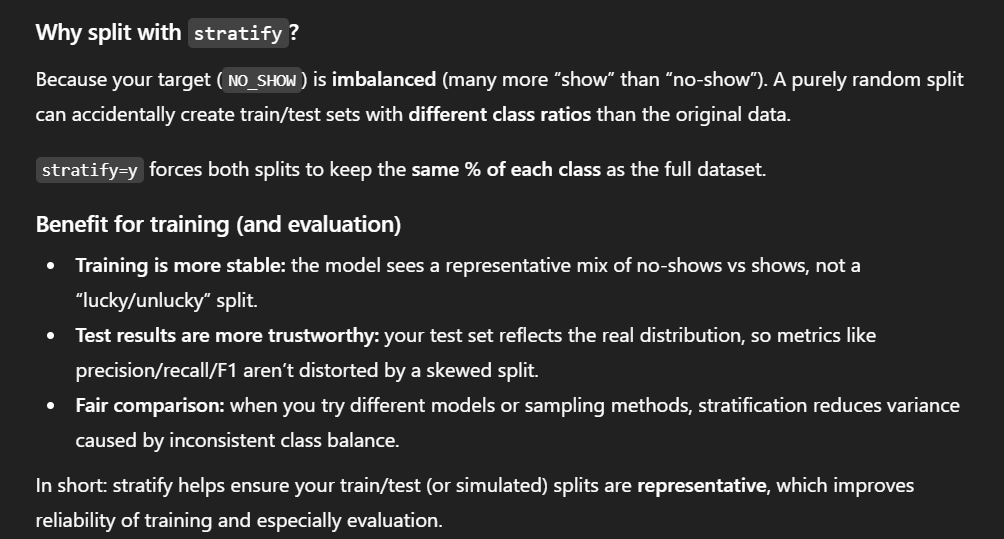

In [7]:
# # # Save the DataFrame as a pickle file
# data.to_pickle("./data/input/full_data.pkl")

## Data Inspection
We can first have a look at the apppointment dataset and inspect its basic attributes.

In [8]:
# Read the saved pickle file as DataFrame
data = pd.read_pickle("./data/input/full_data.pkl")

In [9]:
# Check first 5 rows of data frame
data.head()

,PATIENTID,APPOINTMENTID,GENDER,SCHEDULEDDAY,APPOINTMENTDAY,AGE,NEIGHBOURHOOD,SCHOLARSHIP,HYPERTENSION,DIABETES,ALCOHOLISM,HANDICAP,SMS_RECEIVED,NO_SHOW
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589980e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262960e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679510e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841190e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [10]:
# Split the data to maintain the distribution of the target variable
_, simulated_set = train_test_split(
    data, 
    test_size=0.2, 
    stratify=data['NO_SHOW'],  # Stratify based on the target variable
    random_state=42
)

# Set the targets to NaN
simulated_set['NO_SHOW'] = np.nan

# Save the simulated set to a CSV file
simulated_set.to_csv('./data/input/simulated_set.csv', index=False)
# index=False means: don’t write the DataFrame’s index as an extra column in the CSV.

print("Stratified simulated set saved to './data/input/simulated_set.csv'")

Stratified simulated set saved to './data/input/simulated_set.csv'


In [11]:
# Check shape of data frame
data.shape

(110527, 14)

In [12]:
# Check for null values in each column
data.isnull().sum()

PATIENTID         0
APPOINTMENTID     0
GENDER            0
SCHEDULEDDAY      0
APPOINTMENTDAY    0
AGE               0
NEIGHBOURHOOD     0
SCHOLARSHIP       0
HYPERTENSION      0
DIABETES          0
ALCOHOLISM        0
HANDICAP          0
SMS_RECEIVED      0
NO_SHOW           0
dtype: int64

In [13]:
# Check the data types of current columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   PATIENTID       110527 non-null  float64            
 1   APPOINTMENTID   110527 non-null  int64              
 2   GENDER          110527 non-null  object             
 3   SCHEDULEDDAY    110527 non-null  datetime64[ns, UTC]
 4   APPOINTMENTDAY  110527 non-null  datetime64[ns, UTC]
 5   AGE             110527 non-null  int64              
 6   NEIGHBOURHOOD   110527 non-null  object             
 7   SCHOLARSHIP     110527 non-null  int64              
 8   HYPERTENSION    110527 non-null  int64              
 9   DIABETES        110527 non-null  int64              
 10  ALCOHOLISM      110527 non-null  int64              
 11  HANDICAP        110527 non-null  int64              
 12  SMS_RECEIVED    110527 non-null  int64              
 13  NO_SHOW       

#### From above info, we can see that GENDER and NEIGHBOURHOOD are categorical (object) column

In [14]:
# To see the unique value counts in gender column
data['GENDER'].value_counts()

GENDER
F    71840
M    38687
Name: count, dtype: int64

In [15]:
# Display distinct values in the 'GENDER' column
print(len(data['GENDER'].unique()))

2


In [16]:
# Show the number of unique GENDER values after stripping spaces (without changing the data)
print(len(data['GENDER'].str.strip().unique()))

2


In [17]:
data['NEIGHBOURHOOD'].value_counts()

NEIGHBOURHOOD
JARDIM CAMBURI                 7717
MARIA ORTIZ                    5805
RESISTÊNCIA                    4431
JARDIM DA PENHA                3877
ITARARÉ                        3514
                               ... 
ILHA DO BOI                      35
ILHA DO FRADE                    10
AEROPORTO                         8
ILHAS OCEÂNICAS DE TRINDADE       2
PARQUE INDUSTRIAL                 1
Name: count, Length: 81, dtype: int64

In [18]:
# Display distinct values in the 'NEIGHBOURHOOD' column
print(len(data['NEIGHBOURHOOD'].unique()))

81


In [19]:
# Show the number of unique NEIGHBOURHOOD values after stripping spaces (without changing the data)
print(len(data['NEIGHBOURHOOD'].str.strip().unique()))

81


In [20]:
data['NO_SHOW'].value_counts()

NO_SHOW
No     88208
Yes    22319
Name: count, dtype: int64

In [21]:
# Display distinct values in the 'NO_SHOW' column
print(len(data['NO_SHOW'].unique()))

2


In [22]:
# Show the number of unique NO_SHOW values after stripping spaces (without changing the data)
print(len(data['NO_SHOW'].str.strip().unique()))

2


**Observations**
1. *PATIENTID* is not needed as we're predicting the No-shows per appointment basis. *APPOINTMENTID* can be used as index as it represents each unique appointment. There will be multiple appointments from same patient, so we cannot take PATIENTID as unique appointment identifier.
2. *GENDER* and *NEIGHBOURHOOD* are both categorical features and can be numerically encoded.
3. *NO_SHOW*, our target variable, should also be numerically encoded so that it can be predicted via machine learning.

## Hypothesis-based Exploratory Data Analysis
As mentioned, with utilizing Snowflake SQL, a hypothesis based Exploratory Data Analysis was performed to test out our assumptions. The hypotheses (educated guess) are as below, for detailed work of the SQL queries, please refer to `Snowflake assets\Hypothesis based EDA.sql`.

### Hypothesis 1: Do Males tend to miss more appointments than Females? 

<details><summary> Click here for SQL query </summary>
    
``` SQL
SELECT 
    Gender,
    COUNT(*) AS Total_Appointments,
    SUM(CASE WHEN No_show = 'Yes' THEN 1 ELSE 0 END) AS Missed_Appointments,
    ROUND((SUM(CASE WHEN No_show = 'Yes' THEN 1 ELSE 0 END) / COUNT(*) * 100),1) AS Percentage_Missed
FROM 
    APPOINTMENT_DATA
GROUP BY 
    Gender;

``` 
</details>
<details><summary> Click here for Observations </summary> 
    
 - Both males and females have a similar rate of missing appointments, around 20%.

    <img src="Notebook_images/Hypothesis 1.png" alt="Image" style="width: 90%; height: 80%;" />
    
</details>

### Hypothesis 2: Is there relationship between scheduled-appointment day difference, and patient no-show?

<details><summary> Click here for SQL query </summary>

```SQL
WITH TimeDifference AS (
    SELECT 
        DATEDIFF(day, ScheduledDay, AppointmentDay) AS DaysDifference,
        No_show
    FROM 
        APPOINTMENT_DATA
)
SELECT 
    DaysDifference,
    COUNT(*) AS Total_Appointments,
    SUM(CASE WHEN No_show = 'Yes' THEN 1 ELSE 0 END) AS Missed_Appointments,
    ROUND((SUM(CASE WHEN No_show = 'Yes' THEN 1 ELSE 0 END) / COUNT(*) * 100),1) AS Percentage_Missed
FROM 
    TimeDifference
GROUP BY 
    DaysDifference
ORDER BY 
    DaysDifference;
```
</details>
<details><summary> Click here for Observations </summary>

- There are 5 appointments with negative days difference which they all have 100% missed appointment rate because they were scheduled for past date. This could be due to data entry errors.
- A significant number of appointments (38,563) are scheduled on the same day, with a relatively low missed appointment rate of 4.6%.

    <img src="Notebook_images/Hypothesis 2a.png" alt="Image" style="width: 90%; height: 80%;" />

- For time differences between 1 day to 80 days, the missed appointment rate fluctuates but generally stays within the range of around 20% to 40%.
- The longer time differences (>80 days) have varying missed appointment rates, like on:
    - day 83 (12.5%), 86 (16.7%)
    - day 103 (60%), day 104 (75%)
    - day 112, 115, 117, 119, 122 (0%) 
    - day 132, 139, 146, 151 (100%)

    <img src="Notebook_images/Hypothesis 2b.png" alt="Image" style="width: 90%; height: 90%;" />
</details>

### Hypothesis 3: Is the no-show common among adult patients aged between 18-30?

<details><summary> Click here for SQL query </summary>
    
```SQL
WITH AgeGroups AS (
    SELECT 
        CASE 
            WHEN Age BETWEEN 0 AND 12 THEN '0-12'
            WHEN Age BETWEEN 13 AND 17 THEN '13-17'
            WHEN Age BETWEEN 18 AND 30 THEN '18-30'
            WHEN Age BETWEEN 31 AND 50 THEN '31-50'
            ELSE '50+'
        END AS AgeGroup,
        No_show
    FROM 
        APPOINTMENT_DATA
)
SELECT 
    AgeGroup,
    COUNT(*) AS Total_Appointments,
    SUM(CASE WHEN No_show = 'Yes' THEN 1 ELSE 0 END) AS Missed_Appointments,
    ROUND((SUM(CASE WHEN No_show = 'Yes' THEN 1 ELSE 0 END) / COUNT(*) * 100),1) AS Percentage_Missed
FROM 
    AgeGroups
GROUP BY 
    AgeGroup
ORDER BY 
    AgeGroup;
```
</details>
<details><summary> Click here for Observations </summary>

- The age group of 13-17 years has the highest no-show rate at 26.6% (even they have least appointments scheduled), followed by age group of 18-30 with 24.6%  missed appointment rate.
- In contrast, the age group 50+ years has the lowest no-show rate at 16.2% (even they have highest number of appointments scheduled).

    <img src="Notebook_images/Hypothesis 3a.png" alt="Image" style="width: 90%; height: 80%;" />

    <img src="Notebook_images/Hypothesis 3b.png" alt="Image" style="width: 90%; height: 80%;" />

</details>

## Data Preprocessing
Based on the observations in the Data Inspection section, we will take the following preprocessing steps:
1. Drop *PATIENTID* column
2. Set *APPOINTMENTID* as index
3. Numerical encode target variable: *NO_SHOW*
4. Drop rows which the *APPOINTMENTDAY* comes before *SCHEDULEDDAY*. 
5. Drop rows with negative *AGE*.

The categorical input features *GENDER* and *NEIGHBOURHOOD* will be numerically encoded in feature engineering step.

### Drop redundant column(s)
We will drop the *PATIENTID* column as *APPOINTMENTID* is the more appropriate unique identifier for this dataset. 

In [23]:
# Define a list of column names to drop from the DataFrame
cols_to_drop = ['PATIENTID']

In [24]:
# Create a copy of the original DataFrame to avoid modifying the original data
data_pre = data.copy()

In [25]:
# Print the shape of the DataFrame before dropping columns
print("Before dropping: ", data_pre.shape)

# Drop interested columns and print the shape of the DataFrame after dropping columns
data_pre = data_pre.drop(cols_to_drop, axis=1) # axis = 1 indicates columns
print("After dropping: ", data_pre.shape)

Before dropping:  (110527, 14)
After dropping:  (110527, 13)


In [26]:
data.head(3)

,PATIENTID,APPOINTMENTID,GENDER,SCHEDULEDDAY,APPOINTMENTDAY,AGE,NEIGHBOURHOOD,SCHOLARSHIP,HYPERTENSION,DIABETES,ALCOHOLISM,HANDICAP,SMS_RECEIVED,NO_SHOW
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589980e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262960e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No


### Reset index
The column APPOINTMENTID is the unique identifier to each individual appointment, therefore we can reset the Dataframe index to the APPOINTMENTID.

In [27]:
# Print the total number of rows in the DataFrame
print(f"Rows in data frame: {data_pre.shape[0]}")

Rows in data frame: 110527


In [28]:
# Print the count of unique values in the 'APPOINTMENTID' column of the DataFrame
print(f"Unique value in APPOINTMENTID column: {data_pre['APPOINTMENTID'].nunique()}")

Unique value in APPOINTMENTID column: 110527


In [29]:
# YOU CAN SEE THAT PATIENTID HAS LESS UNIQUE VALUES THAN APPOINTMENTID
print(f"Unique value in PATIENTID column: {data['PATIENTID'].nunique()}")

Unique value in PATIENTID column: 61744


In [30]:
# Set the 'APPOINTMENTID' column as the index of the DataFrame 'data_pre'
data_pre.set_index('APPOINTMENTID', inplace=True) # inplace=True to modify the DataFrame directly

In [31]:
# Display the first 5 rows of the DataFrame
data_pre.head()

,GENDER,SCHEDULEDDAY,APPOINTMENTDAY,AGE,NEIGHBOURHOOD,SCHOLARSHIP,HYPERTENSION,DIABETES,ALCOHOLISM,HANDICAP,SMS_RECEIVED,NO_SHOW
APPOINTMENTID,,,,,,,,,,,,
5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No
5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No
5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No
5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [32]:
# Check shape of data frame
data_pre.shape

(110527, 12)

### Numeric encode categorical target variable (No-Show)
The target variable *NO_SHOW* contains *yes/no* character Boolean, we can encode it to numeric Boolean of *1/0*.

In [33]:
# Get the unique values in the 'NO_SHOW' column before encoding
data_pre['NO_SHOW'].unique()

array(['No', 'Yes'], dtype=object)

In [34]:
# Encode the 'NO_SHOW' column, where 'No' becomes 0 and 'Yes' becomes 1
data_pre['NO_SHOW'] = data_pre['NO_SHOW'].map({'No': 0, 'Yes': 1})

# Display the unique values in the 'NO_SHOW' column to verify the encoding
data_pre['NO_SHOW'].unique()

array([0, 1], dtype=int64)

### Drop rows for appointment day comes before schedule day 
We can see ther are some records where the appointment day comes before schedule day, this could due to data entry error so we will drop these records.

In [35]:
# Filter records where the calculated 'DAYS_TILL_APPOINTMENT' would be negative
negative_days_records = data_pre[(data_pre['APPOINTMENTDAY'] - data_pre['SCHEDULEDDAY']).dt.days + 1 < 0]
negative_days_records

# dt is a pandas accessor for datetime columns.
# It allows you to use datetime properties and methods, like .days, .month, .year, etc.
# data_pre['APPOINTMENTDAY'] - data_pre['SCHEDULEDDAY'] computes the difference between two datetime columns, resulting in a timedelta object.
# .dt.days extracts the number of days from that timedelta.
# + 1 adjusts the calculation so that appointments scheduled and held on the same day count as 1 day (not 0).

,GENDER,SCHEDULEDDAY,APPOINTMENTDAY,AGE,NEIGHBOURHOOD,SCHOLARSHIP,HYPERTENSION,DIABETES,ALCOHOLISM,HANDICAP,SMS_RECEIVED,NO_SHOW
APPOINTMENTID,,,,,,,,,,,,
5679978,M,2016-05-10 10:51:53+00:00,2016-05-09 00:00:00+00:00,38,RESISTÊNCIA,0,0,0,0,1,0,1
5715660,F,2016-05-18 14:50:41+00:00,2016-05-17 00:00:00+00:00,19,SANTO ANTÔNIO,0,0,0,0,1,0,1
5664962,F,2016-05-05 13:43:58+00:00,2016-05-04 00:00:00+00:00,22,CONSOLAÇÃO,0,0,0,0,0,0,1
5686628,F,2016-05-11 13:49:20+00:00,2016-05-05 00:00:00+00:00,81,SANTO ANTÔNIO,0,0,0,0,0,0,1
5655637,M,2016-05-04 06:50:57+00:00,2016-05-03 00:00:00+00:00,7,TABUAZEIRO,0,0,0,0,0,0,1


In [36]:
# Count the number of such records
count_negative_days = len(negative_days_records)

# Print the count and the records
print(f"Number of records with negative Days Till Appointment: {count_negative_days}")

Number of records with negative Days Till Appointment: 5


In [37]:
data_pre.shape

(110527, 12)

In [38]:
# Drop records where the calculated 'DAYS_TILL_APPOINTMENT' would be negative
data_pre = data_pre[(data_pre['APPOINTMENTDAY'] - data_pre['SCHEDULEDDAY']).dt.days + 1 >= 0]

In [39]:
# Check shape of data frame
data_pre.shape

(110522, 12)

In [40]:
data_pre.describe()

,AGE,SCHOLARSHIP,HYPERTENSION,DIABETES,ALCOHOLISM,HANDICAP,SMS_RECEIVED,NO_SHOW
count,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000
mean,37.089041,0.098270,0.197255,0.071868,0.030401,0.022231,0.321040,0.201896
std,23.110064,0.297681,0.397928,0.258270,0.171689,0.161493,0.466878,0.401417
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000


### Drop rows with negative age
There's 1 record with with age < 0, we can drop this row since it's not realistic to have age of -1.

Before we proceed, let's have a quick check and see if the age is within the valid range.

In [41]:
# Display the minimum and maxiumum age 
print("Minimum age:", data_pre['AGE'].min())
print("Maximum age:", data_pre['AGE'].max())

Minimum age: -1
Maximum age: 115


The minimum age of -1 does not make sense, let's have a look at how many records have age below 0.

In [42]:
# Filter records where AGE is -1
records_with_negative_age = data_pre[data_pre['AGE'] < 0]
records_with_negative_age

,GENDER,SCHEDULEDDAY,APPOINTMENTDAY,AGE,NEIGHBOURHOOD,SCHOLARSHIP,HYPERTENSION,DIABETES,ALCOHOLISM,HANDICAP,SMS_RECEIVED,NO_SHOW
APPOINTMENTID,,,,,,,,,,,,
5775010,F,2016-06-06 08:58:13+00:00,2016-06-06 00:00:00+00:00,-1,ROMÃO,0,0,0,0,0,0,0


In [43]:
# Get the total number of records where AGE is -1
total_records_negative_age = len(records_with_negative_age)

# Display the records and total number of records with AGE = -1
print(f"Total number of records with AGE < 0: {total_records_negative_age}")

Total number of records with AGE < 0: 1


In [44]:
data_pre.shape

(110522, 12)

In [45]:
# Drop records where AGE is less than 0
data_pre = data_pre[data_pre['AGE'] >= 0]

In [46]:
# Check shape of data frame
data_pre.shape

(110521, 12)

In [47]:
# Display the minimum and maxiumum age 
print("Minimum age:", data_pre['AGE'].min())
print("Maximum age:", data_pre['AGE'].max())

Minimum age: 0
Maximum age: 115


Now a minimum of 0 and maximum of 115 seem to be a valid range for age. 

## Statistical Testing
In this section, we will apply Statistical Testing to help understand the impact of the features on the target. For example:
1. Perform Chi-square test between *Gender* and the target variable (*No-show*) to see if Gender impacts the target.
2. Perform Chi-square test between *Alcoholism* and the target variable (*No-show*) to see if Alcoholism impacts the target.
3. Is sending messages to the patients really useful? Check its significance with the target variable using relevant testing techniques.

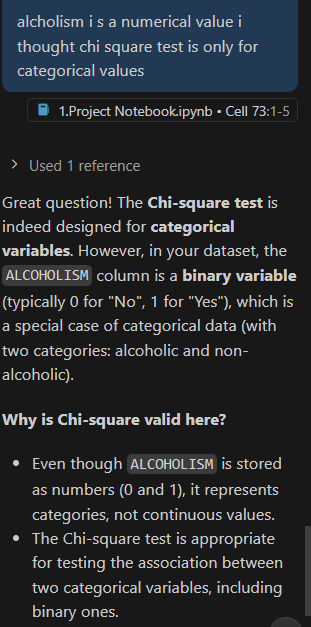   

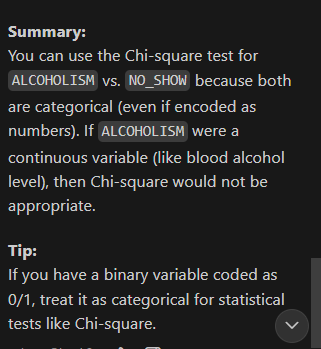

In [48]:
# Get the number of unique values for each column in the DataFrame
print(data.nunique())

PATIENTID          61744
APPOINTMENTID     110527
GENDER                 2
SCHEDULEDDAY      103549
APPOINTMENTDAY        27
AGE                  104
NEIGHBOURHOOD         81
SCHOLARSHIP            2
HYPERTENSION           2
DIABETES               2
ALCOHOLISM             2
HANDICAP               5
SMS_RECEIVED           2
NO_SHOW                2
dtype: int64


In [49]:
# Display all unique values for each column in the DataFrame
unique_values = {col: data[col].unique() for col in data.columns}
for col, vals in unique_values.items():
    print(f"{col}: {vals}\n")

PATIENTID: [2.98725e+13 5.58998e+14 4.26296e+12 ... 7.26331e+13 9.96998e+14
 1.55766e+13]

APPOINTMENTID: [5642903 5642503 5642549 ... 5630692 5630323 5629448]

GENDER: ['F' 'M']

SCHEDULEDDAY: <DatetimeArray>
['2016-04-29 18:38:08+00:00', '2016-04-29 16:08:27+00:00',
 '2016-04-29 16:19:04+00:00', '2016-04-29 17:29:31+00:00',
 '2016-04-29 16:07:23+00:00', '2016-04-27 08:36:51+00:00',
 '2016-04-27 15:05:12+00:00', '2016-04-27 15:39:58+00:00',
 '2016-04-29 08:02:16+00:00', '2016-04-27 12:48:25+00:00',
 ...
 '2016-06-07 07:45:16+00:00', '2016-06-07 07:38:34+00:00',
 '2016-04-27 15:15:06+00:00', '2016-05-03 07:51:47+00:00',
 '2016-05-03 08:23:40+00:00', '2016-05-03 09:15:35+00:00',
 '2016-05-03 07:27:33+00:00', '2016-04-27 16:03:52+00:00',
 '2016-04-27 15:09:23+00:00', '2016-04-27 13:30:56+00:00']
Length: 103549, dtype: datetime64[ns, UTC]

APPOINTMENTDAY: <DatetimeArray>
['2016-04-29 00:00:00+00:00', '2016-05-03 00:00:00+00:00',
 '2016-05-10 00:00:00+00:00', '2016-05-17 00:00:00+00:00',
 

### Chi-Square Test for Independence: Gender and No-Show    

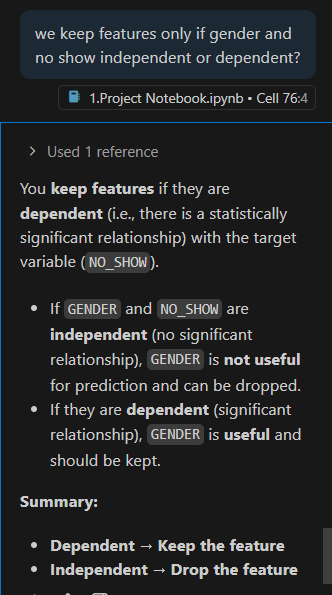   

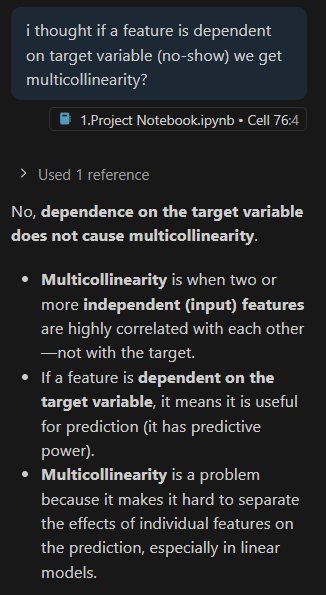    

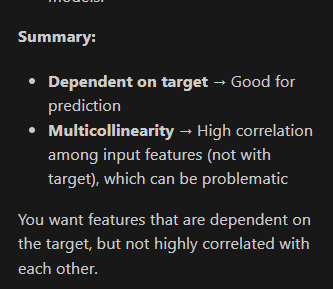  

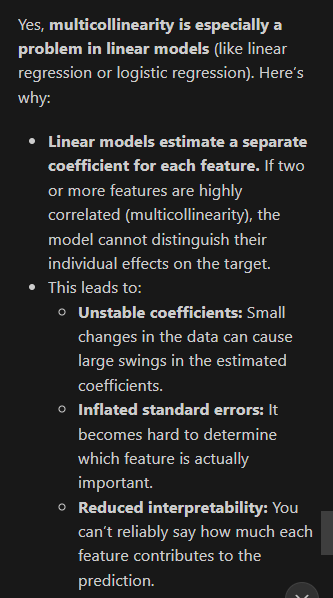  

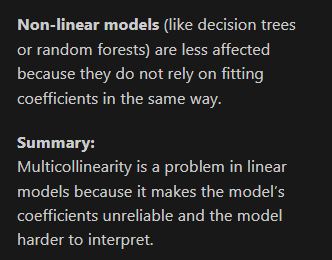  

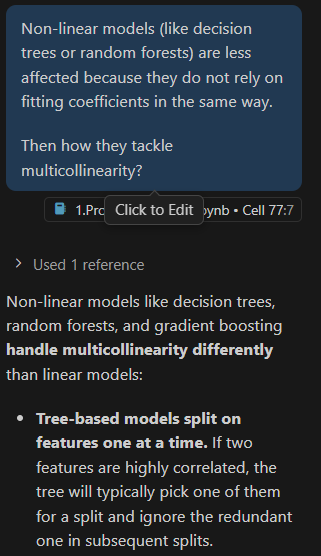  

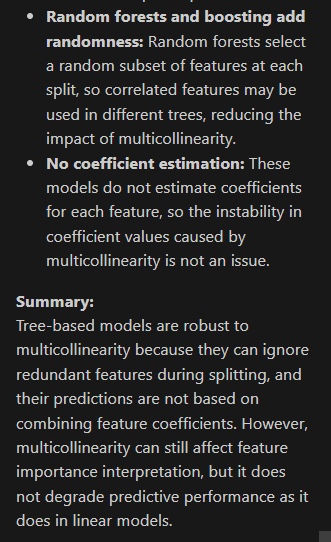  

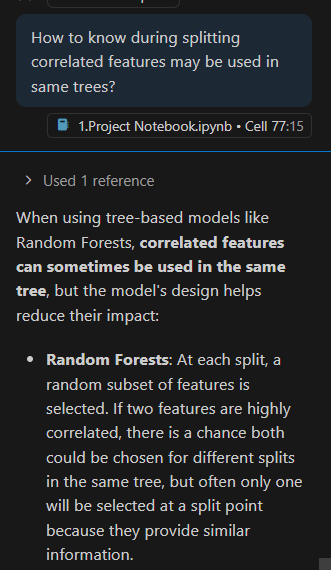

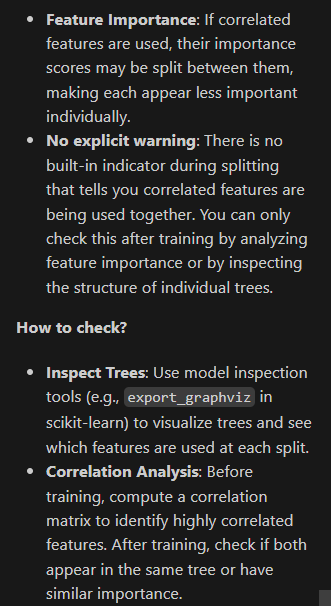  

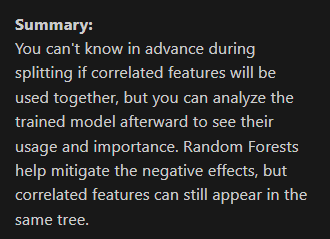  

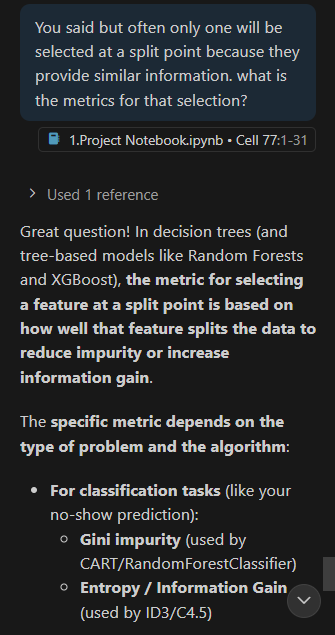  

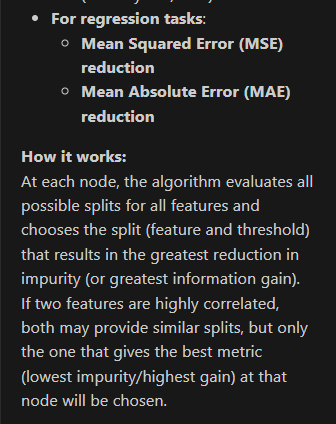  

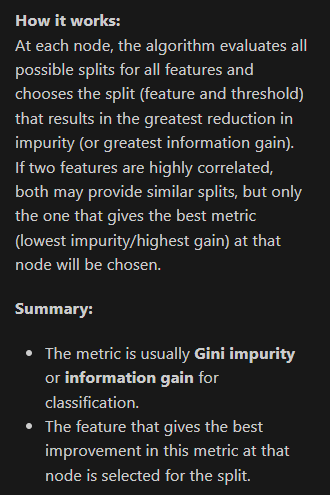

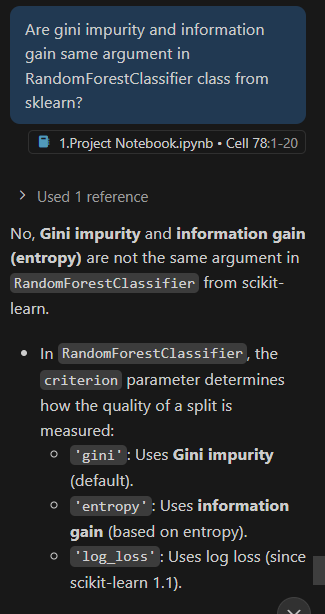



```python
from sklearn.ensemble import RandomForestClassifier

# Using Gini impurity (default)
clf_gini = RandomForestClassifier(criterion='gini')

# Using information gain (entropy)
clf_entropy = RandomForestClassifier(criterion='entropy')  

```


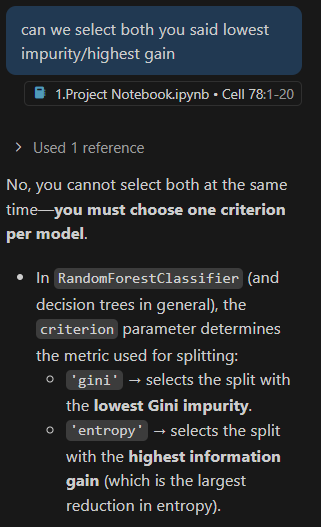  

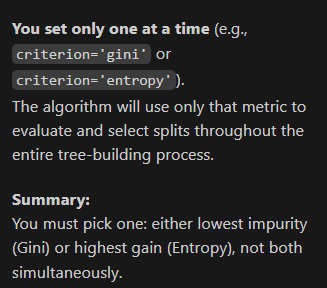


**Objective**<br>
To determine if there is a statistically significant relationship between the gender of the patient (*GENDER*) and the likelihood of missing an appointment (*NO_SHOW*).

**Null Hypothesis (H0)**<br>
The gender of the patient is independent of whether they will miss an appointment. In other words, gender does not impact the likelihood of a no-show.

**Alternative Hypothesis (H1)**<br>
The gender of the patient is not independent of whether they will miss an appointment. In other words, gender does impact the likelihood of a no-show.

**Significance Level**<br>
We will use a significance level ($\alpha$) of 0.05 for this test.

**Expected Outcome**<br>
If the p-value is less than the significance level, we will reject the null hypothesis, suggesting that gender does have an impact on the likelihood of a no-show. Otherwise, we will fail to reject the null hypothesis, suggesting that the two variables are independent.

In [50]:
# Create the contingency table for Gender and NO_SHOW
contingency_table_gender = pd.crosstab(data_pre['GENDER'], data_pre['NO_SHOW'])
# A contingency table is a matrix that displays the frequency counts of observations for combinations of 
# two categorical variables—in this case, 
# showing how many appointments for each gender resulted in a show or no-show.
contingency_table_gender

NO_SHOW,0,1
GENDER,,
F,57245,14591
M,30962,7723


In [51]:
contingency_table_gender

NO_SHOW,0,1
GENDER,,
F,57245,14591
M,30962,7723


In [52]:
data.columns

Index(['PATIENTID', 'APPOINTMENTID', 'GENDER', 'SCHEDULEDDAY',
       'APPOINTMENTDAY', 'AGE', 'NEIGHBOURHOOD', 'SCHOLARSHIP', 'HYPERTENSION',
       'DIABETES', 'ALCOHOLISM', 'HANDICAP', 'SMS_RECEIVED', 'NO_SHOW'],
      dtype='object')

In [53]:
contingency_table_gender[0] # No-Show = 0

GENDER
F    57245
M    30962
Name: 0, dtype: int64

In [54]:
len(contingency_table_gender[0])

2

In [55]:
contingency_table_gender[1] # No-Show = 1

GENDER
F    14591
M     7723
Name: 1, dtype: int64

In [56]:
len(contingency_table_gender[1])

2

In [57]:
range(len(contingency_table_gender[1]))

range(0, 2)

In [58]:
list(range(len(contingency_table_gender[1])))

[0, 1]

In [59]:
for i in range(len(contingency_table_gender[1])):
    print(i)

0
1


In [60]:
# Set positions and width for the bars
pos = list(range(len(contingency_table_gender[1])))
print(type(pos))
print(pos)

<class 'list'>
[0, 1]


In [61]:
contingency_table_gender = pd.crosstab(data_pre['GENDER'], data_pre['NO_SHOW'])
contingency_table_gender


NO_SHOW,0,1
GENDER,,
F,57245,14591
M,30962,7723


In [62]:
# # Reorder the contingency table to have 'M' first in bar chart, then 'F'
# contingency_table_gender = contingency_table_gender.reindex(['M', 'F'])
# contingency_table_gender

In [63]:
contingency_table_gender[1] # No-Show = 1

GENDER
F    14591
M     7723
Name: 1, dtype: int64

In [64]:
pos

[0, 1]

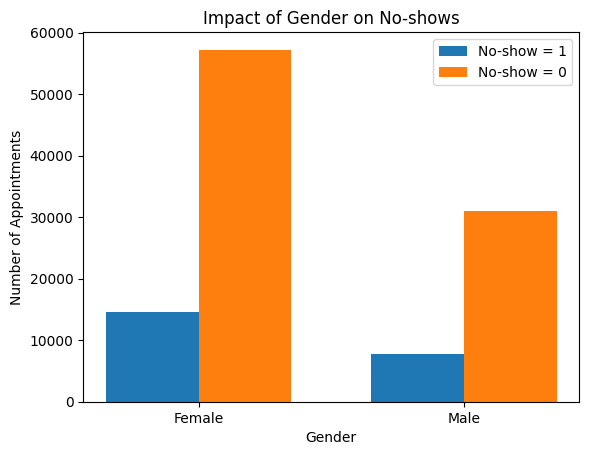

In [65]:
# Create the contingency table for Gender and NO_SHOW

contingency_table_gender = pd.crosstab(data_pre['GENDER'], data_pre['NO_SHOW'])

# Reorder the contingency table to have 'M' first, then 'F'
# contingency_table_gender = contingency_table_gender.reindex(['M', 'F'])
## In that case you will have to change ax.set_xticklabels(['Female', 'Male']) to ax.set_xticklabels(['Male', 'Female'])


# Plotting the bar chart
fig, ax = plt.subplots()

# Set positions and width for the bars
pos = list(range(len(contingency_table_gender[1])))
bar_width = 0.35

# F and M who is not showed up (No-show = 1)
plt.bar(pos, contingency_table_gender[1], bar_width, label='No-show = 1')

# F and M who is showed up (No-show = 0)
plt.bar([p + bar_width for p in pos], contingency_table_gender[0], bar_width, label='No-show = 0')

# Set axis labels and title
ax.set_xticks([p + 0.5 * bar_width for p in pos])
ax.set_xticklabels(['Female', 'Male'])
# ax.set_xticklabels(['Male', 'Female'])
plt.xlabel('Gender')
plt.ylabel('Number of Appointments')
plt.title('Impact of Gender on No-shows')

# Add legend
plt.legend()

# Show the plot
plt.show()  

# The order of the bars (Female first, Male second) is determined by the order of the index in your contingency table
# By default, pd.crosstab sorts the index alphabetically. Since 'F' comes before 'M', the first row is Female, the second is Male. That's why your bars are plotted as Female first, then Male.

In [66]:
contingency_table = pd.crosstab(data_pre['GENDER'], data_pre['NO_SHOW'])
contingency_table

NO_SHOW,0,1
GENDER,,
F,57245,14591
M,30962,7723


In [67]:
# Create a contingency table
# This table will show the frequency distribution of no-shows across different genders
contingency_table = pd.crosstab(data_pre['GENDER'], data_pre['NO_SHOW'])

# Perform the Chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
# chi2: The Chi-square test statistic.
# It measures how much the observed counts (actual data)
# deviate from the expected counts (if Gender and No-Show were independent).

# p_value: The p-value for the test. It tells you the probability of observing a 
# chi-square value as extreme as (or more extreme than)
# the one calculated, assuming the null hypothesis (independence) is true.
# If p_value < 0.05, you reject the null hypothesis (there is a significant relationship).

# dof: The degrees of freedom for the test.
# Calculated as (number of rows - 1) * (number of columns - 1) in the contingency table.

# expected: The expected frequencies table. This is a NumPy array of the expected counts for 
# each cell in the contingency table, assuming the variables are independent.

# Print the results of the Chi-square test
print("Results")
print(f"Chi-square value: {chi2}") # The Chi-square statistic
print(f"P-value: {p_value}") # The p-value of the test
print(f"Degrees of Freedom: {dof}") # Degrees of freedom
print("Expected Frequencies Table:")
print(expected) # The expected frequencies table


# Interpret the results based on the p-value and a significance level of 0.05
alpha = 0.05  # Significance level
# The value 0.05 is a conventional threshold for statistical significance, known as the significance level (α).
print("\nConclusion")
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant relationship between Gender and No-show.")
else:
    print("Fail to reject the null hypothesis. There is no significant relationship between Gender and No-show.")

Results
Chi-square value: 1.8653434872450756
P-value: 0.172009349904053
Degrees of Freedom: 1
Expected Frequencies Table:
[[57332.43503045 14503.56496955]
 [30874.56496955  7810.43503045]]

Conclusion
Fail to reject the null hypothesis. There is no significant relationship between Gender and No-show.


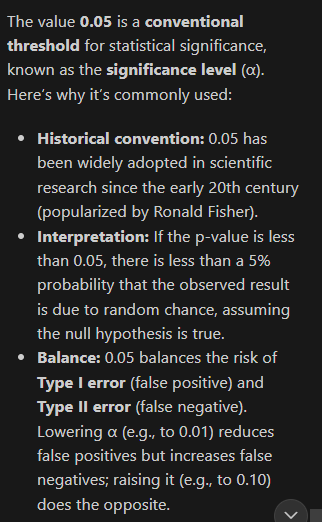

### Chi-Square Test for Independence: Alcoholism and No-Show
**Objective**<br>
To determine if there is a statistically significant relationship between the alcoholism status of the patient (*Alcoholism*) and the likelihood of missing an appointment (*NO_SHOW*).

**Null Hypothesis (H0)**<br>
The alcoholism status of the patient is independent of whether they will miss an appointment. In other words, alcoholism does not impact the likelihood of a no-show.

**Alternative Hypothesis (H1)**<br>
The alcoholism status of the patient is not independent of whether they will miss an appointment. In other words, alcoholism does impact the likelihood of a no-show.

**Significance Level**<br>
We will use a significance level ($\alpha$) of 0.05 for this test.

**Expected Outcome**<br>
If the p-value is less than the significance level, we will reject the null hypothesis, suggesting that alcoholism does have an impact on the likelihood of a no-show. Otherwise, we will fail to reject the null hypothesis, suggesting that the two variables are independent.

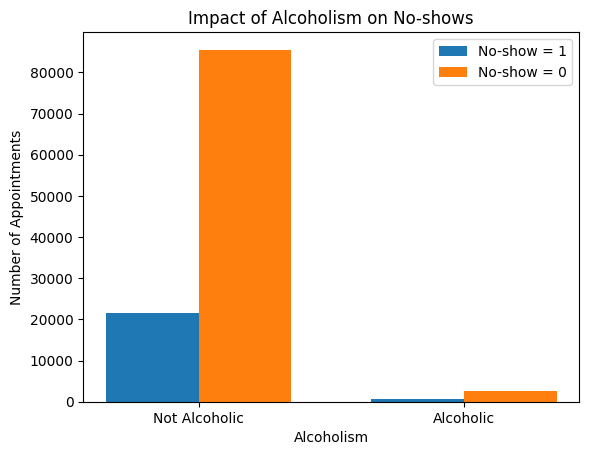

In [68]:
# Create the contingency table for Alcoholism and NO_SHOW
contingency_table_alcoholism = pd.crosstab(data_pre['ALCOHOLISM'], data_pre['NO_SHOW'])

# Plotting the bar chart
fig, ax = plt.subplots()

# Set positions and width for the bars
pos = list(range(len(contingency_table_alcoholism[1])))
bar_width = 0.35

# Plot bars for '1' and '0' in 'NO_SHOW'
plt.bar(pos, contingency_table_alcoholism[1], bar_width, label='No-show = 1')
plt.bar([p + bar_width for p in pos], contingency_table_alcoholism[0], bar_width, label='No-show = 0')

# Set axis labels and title
ax.set_xticks([p + 0.5 * bar_width for p in pos])
ax.set_xticklabels(['Not Alcoholic', 'Alcoholic'])
plt.xlabel('Alcoholism')
plt.ylabel('Number of Appointments')
plt.title('Impact of Alcoholism on No-shows')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [69]:
# Create a contingency table
# This table will show the frequency distribution of no-shows across patients with and without alcoholism
contingency_table_alcoholism = pd.crosstab(data_pre['ALCOHOLISM'], data_pre['NO_SHOW'])

# Perform the Chi-square test
chi2_alcoholism, p_value_alcoholism, dof_alcoholism, expected_alcoholism = chi2_contingency(contingency_table_alcoholism)

# Print the results of the Chi-square test
print("Results")
print(f"Chi-square value: {chi2_alcoholism}")  # The Chi-square statistic
print(f"P-value: {p_value_alcoholism}")  # The p-value of the test
print(f"Degrees of Freedom: {dof_alcoholism}")  # Degrees of freedom

# Interpret the results based on the p-value and a significance level of 0.05
alpha = 0.05  # Significance level
print("\nConclusion")
if p_value_alcoholism < alpha:
    print("Reject the null hypothesis. There is a significant relationship between Alcoholism and No-show.")
else:
    print("Fail to reject the null hypothesis. There is no significant relationship between Alcoholism and No-show.")

Results
Chi-square value: 0.0014692349019108986
P-value: 0.9694240933773812
Degrees of Freedom: 1

Conclusion
Fail to reject the null hypothesis. There is no significant relationship between Alcoholism and No-show.


### Chi-Square Test for Independence: SMS Received and No-Show
**Objective**<br>
To determine if there is a statistically significant relationship between receiving an SMS (*SMS_received*) and the likelihood of missing an appointment (*NO_SHOW*).

**Null Hypothesis (H0)**<br>
Receiving an SMS is independent of whether a patient will miss an appointment. In other words, receiving an SMS does not impact the likelihood of a no-show.

**Alternative Hypothesis (H1)**<br>
Receiving an SMS is not independent of whether a patient will miss an appointment. In other words, receiving an SMS does impact the likelihood of a no-show.

**Significance Level**<br>
We will use a significance level ($\alpha$) of 0.05 for this test.

**Expected Outcome**<br>
If the p-value is less than the significance level, we will reject the null hypothesis, suggesting that receiving an SMS does have an impact on the likelihood of a no-show. Otherwise, we will fail to reject the null hypothesis, suggesting that the two variables are independent.

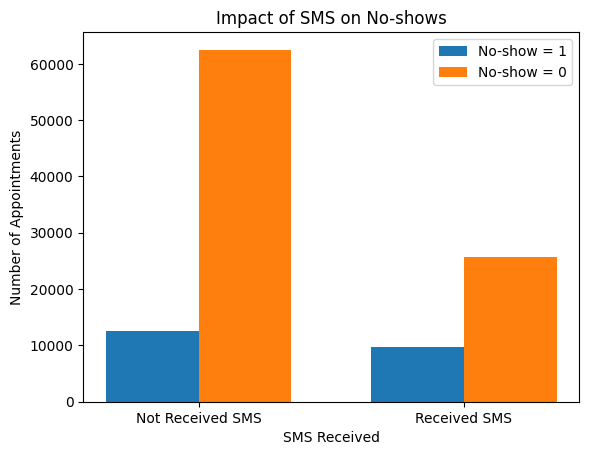

In [70]:
# Create the contingency table
contingency_table_sms = pd.crosstab(data_pre['SMS_RECEIVED'], data_pre['NO_SHOW'])

# Plotting the bar chart
fig, ax = plt.subplots()

# Set the positions and width for the bars
pos = list(range(len(contingency_table_sms[1])))  # Using 1 for no-show
bar_width = 0.35

# Plot bars for '1' and '0' in 'NO_SHOW'
plt.bar(pos, contingency_table_sms[1], bar_width, label='No-show = 1')
plt.bar([p + bar_width for p in pos], contingency_table_sms[0], bar_width, label='No-show = 0')

# Set axis labels and title
ax.set_xticks([p + 0.5 * bar_width for p in pos])
ax.set_xticklabels(['Not Received SMS', 'Received SMS'])
plt.xlabel('SMS Received')
plt.ylabel('Number of Appointments')
plt.title('Impact of SMS on No-shows')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [71]:
# Create a contingency table
# This table will show the frequency distribution of no-shows for patients who received an SMS and those who didn't
contingency_table_sms = pd.crosstab(data_pre['SMS_RECEIVED'], data_pre['NO_SHOW'])

# Perform the Chi-square test
chi2_sms, p_value_sms, dof_sms, expected_sms = chi2_contingency(contingency_table_sms)

# Print the results of the Chi-square test
print("Results")
print(f"Chi-square value: {chi2_sms}")  # The Chi-square statistic
print(f"P-value: {p_value_sms}")  # The p-value of the test
print(f"Degrees of Freedom: {dof_sms}")  # Degrees of freedom

# Interpret the results based on the p-value and a significance level of 0.05
alpha = 0.05  # Significance level
print("\nConclusion")
if p_value_sms < alpha:
    print("Reject the null hypothesis. There is a significant relationship between SMS_received and No-show.")
else:
    print("Fail to reject the null hypothesis. There is no significant relationship between SMS_received and No-show.")

Results
Chi-square value: 1767.9781891546713
P-value: 0.0
Degrees of Freedom: 1

Conclusion
Reject the null hypothesis. There is a significant relationship between SMS_received and No-show.


##  Stratified Hold-out Split (stratified random train–test split)
In this section, we will be performing a stratified hold-out split on the dataset. The goal is to divide the data into training and testing sets while maintaining the distribution of the target variable, *NO_SHOW*, in both subsets. This ensures that the model will be trained and evaluated on data that is representative of the overall distribution of the target variable.

We will also visualize the distribution of *NO_SHOW* before and after the split to confirm that the stratification worked as expected. (Because sample from population should also need to have same distribution)

#### Stratified Holdout Split is nothing but the normal train test split with stratification enabled like in below image

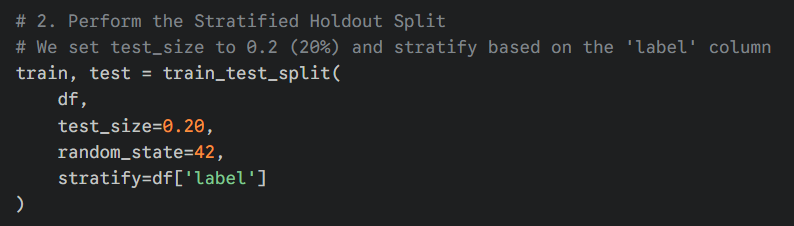

### What if i have X and y instead of only one df is that also called stratified holdout split?  

In machine learning, "holdout" simply refers to the act of "holding out" a portion of your data to test the model later.1 Whether your data is in one single DataFrame or already separated into features ($X$) and labels ($y$), the concept remains the same.    


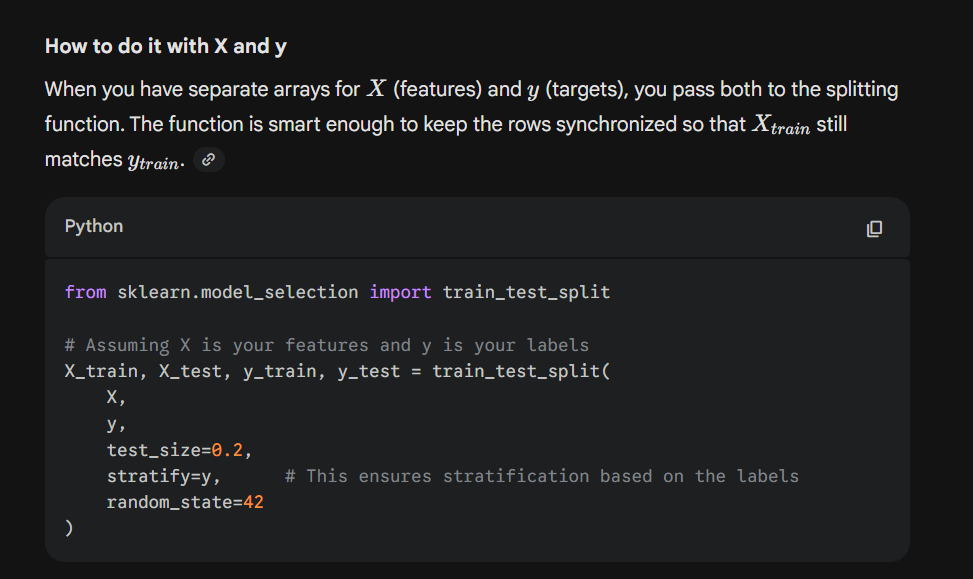

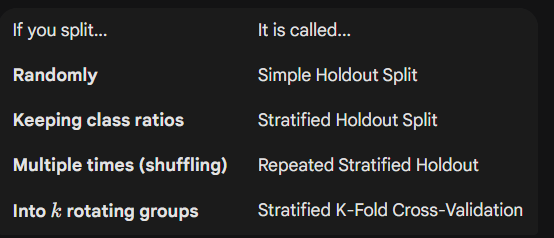   


For more details, please check "additional-learning\Different Form Of Splits in Sklearn"

In [72]:
data_pre.shape

(110521, 12)

In [73]:
# Count the frequency of each unique value in the 'NO_SHOW' column
data_pre['NO_SHOW'].value_counts()

NO_SHOW
0    88207
1    22314
Name: count, dtype: int64

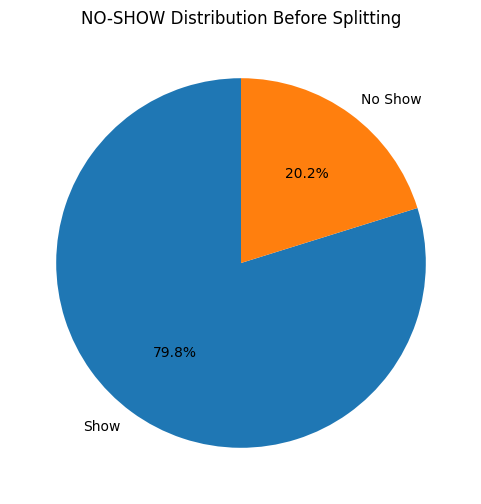

In [74]:
# Visualize the distribution of 'NO_SHOW' before splitting using a pie chart
plt.figure(figsize=(6, 6))
data_pre['NO_SHOW'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, labels=['Show', 'No Show'])
plt.title('NO-SHOW Distribution Before Splitting')
plt.ylabel('')  # Hide the y-axis label for clarity
plt.show()

We can now perform the 80-20 stratified split and verify the target class distribution stays the same before and after splitting. 

<span style="color: red; font-weight: bold; font-size: 30px">SPLITTING</span>

In [75]:
# Perform the 80%-20% stratified split
train_data, test_data = train_test_split(data_pre, test_size=0.2, stratify=data_pre['NO_SHOW'], random_state=42)

In [76]:
print(data_pre.shape[0])
print(data_pre.shape[0] * 0.8)
print(data_pre.shape[0] * 0.2)


110521
88416.8
22104.2


In [77]:
train_data['NO_SHOW'].value_counts()

NO_SHOW
0    70565
1    17851
Name: count, dtype: int64

In [78]:
70565 + 17851

88416

In [79]:
print(data_pre.shape[0])
print(data_pre.shape[0] * 0.8)
print(data_pre.shape[0] * 0.2)


110521
88416.8
22104.2


In [80]:
test_data['NO_SHOW'].value_counts()

NO_SHOW
0    17642
1     4463
Name: count, dtype: int64

In [81]:
17642 + 4463 

22105

In [82]:
train_value_counts = train_data['NO_SHOW'].value_counts(normalize=True) * 100
train_value_counts

NO_SHOW
0    79.810215
1    20.189785
Name: proportion, dtype: float64

In [83]:
test_value_counts = test_data['NO_SHOW'].value_counts(normalize=True) * 100
test_value_counts

NO_SHOW
0    79.809998
1    20.190002
Name: proportion, dtype: float64

In [84]:
# Calculate the value counts for the 'NO_SHOW' column in the training set
train_value_counts = train_data['NO_SHOW'].value_counts(normalize=True) * 100

# Calculate the value counts for the 'NO_SHOW' column in the test set
test_value_counts = test_data['NO_SHOW'].value_counts(normalize=True) * 100

# Round the value counts to 1 decimal place
train_value_counts = train_value_counts.round(1)
test_value_counts = test_value_counts.round(1)

# Display the rounded value counts
print("Training set 'NO_SHOW' value counts (in %):")
display(train_value_counts)

print("\nTest set 'NO_SHOW' value counts (in %):")
display(test_value_counts)

Training set 'NO_SHOW' value counts (in %):


NO_SHOW
0    79.8
1    20.2
Name: proportion, dtype: float64


Test set 'NO_SHOW' value counts (in %):


NO_SHOW
0    79.8
1    20.2
Name: proportion, dtype: float64

In [85]:
# Check the shape of the training set
print(f"Shape of training set: {train_data.shape}")

# Check the shape of the testing set
print(f"Shape of testing set: {test_data.shape}")

Shape of training set: (88416, 12)
Shape of testing set: (22105, 12)


## Feature Engineering and Additional Data Preprocessing
Creating new features or selecting important features from the existing dataset that can help improve the model's performance. This may involve techniques like feature extraction, dimensionality reduction, or creating interaction variables (“Interaction feature” and “interaction variable” mean the same thing in practice.They both refer to a new feature created from two (or more) original features to capture their combined effect on the target.)   


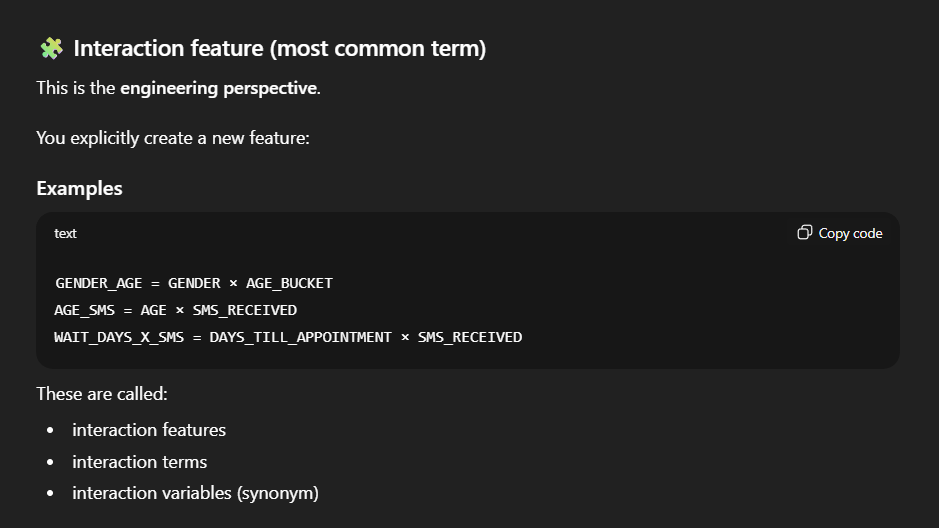   

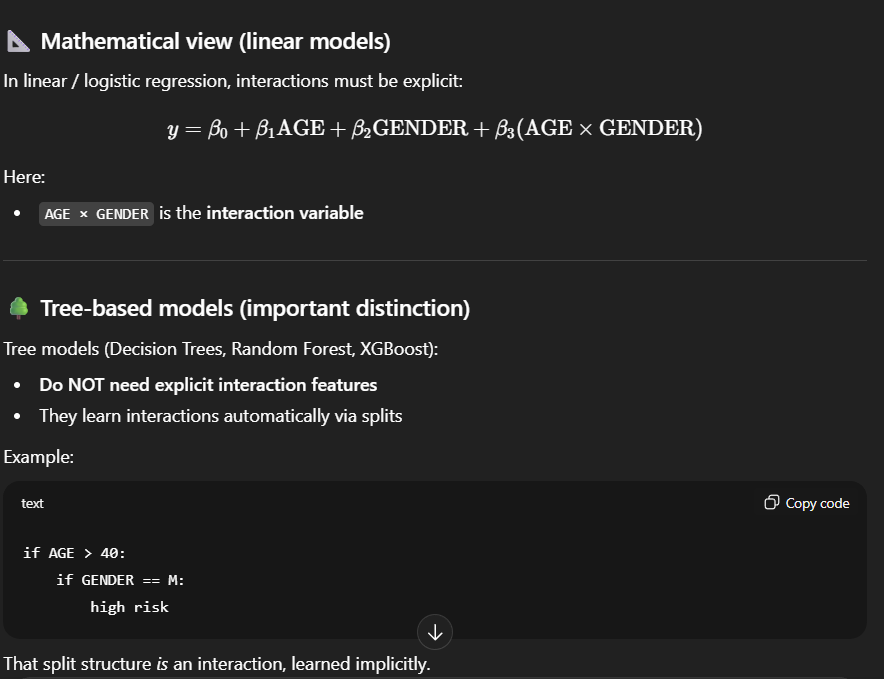  

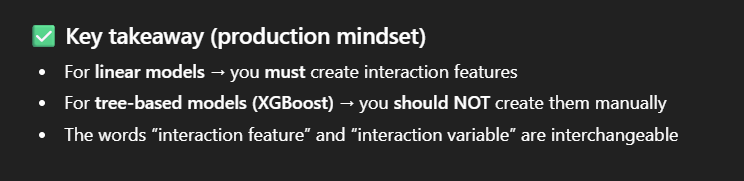  


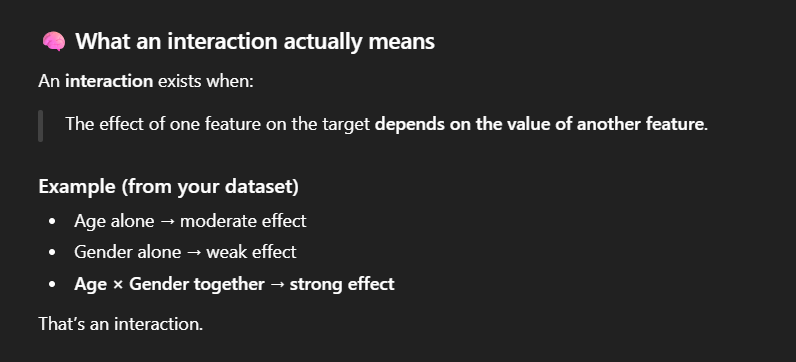

### Create new features
Combining multiple features into a single feature can sometimes reveal interesting patterns that are not apparent when considering the features individually. For example:
1. Analyze how *Gender* and *Age* together impacts the target variable and create a new feature which takes in Gender and Age buckets.
2. Using *Scheduled_Day* and *Appointment_Day*, create a new feature that says days till appointment for each patient.     



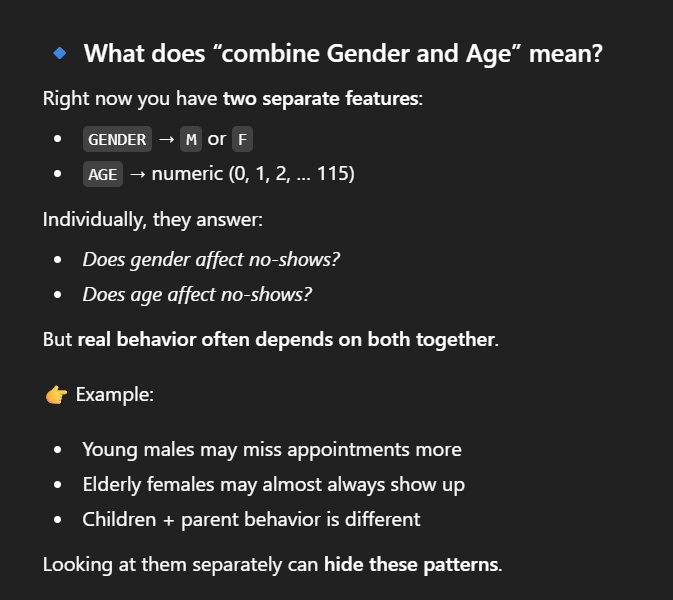   

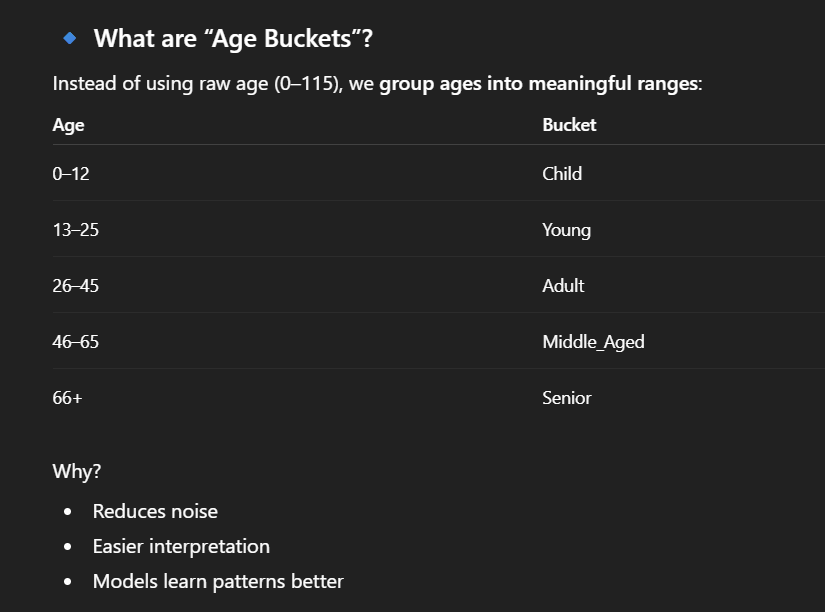  

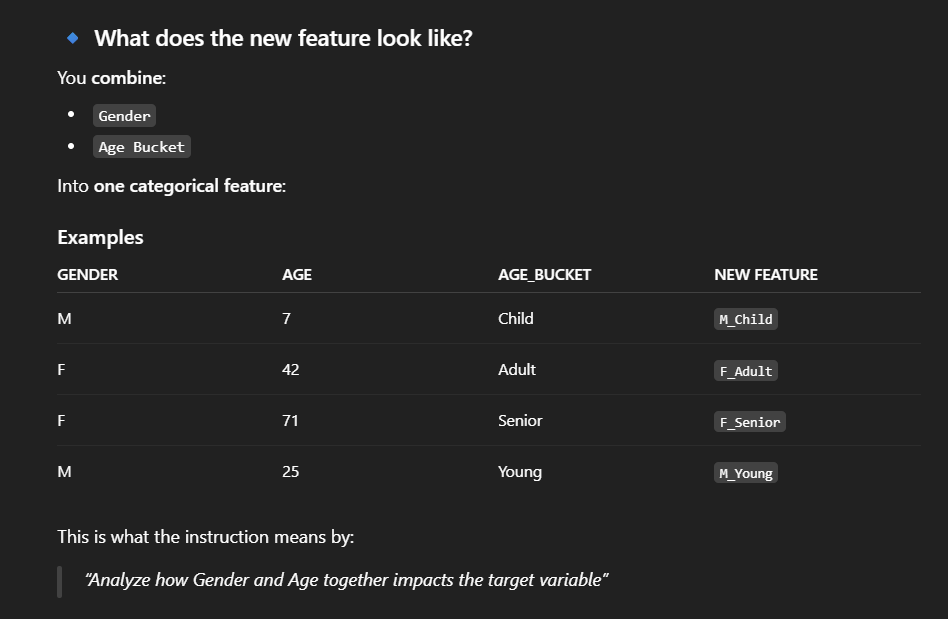  

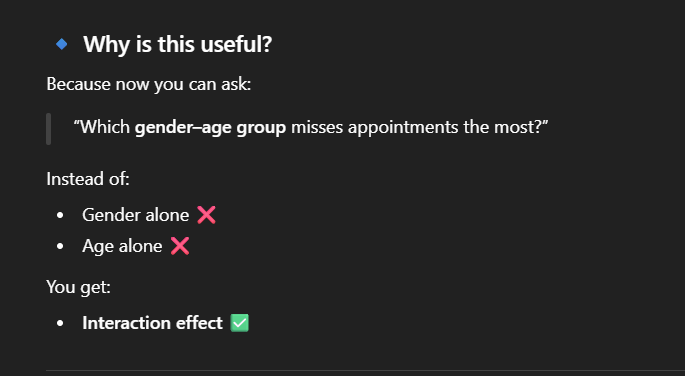  

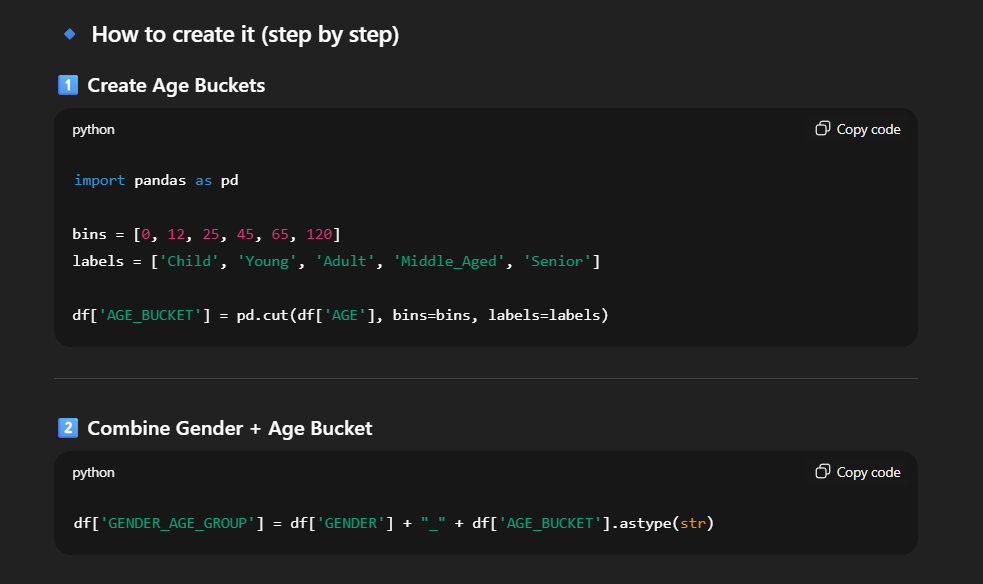  

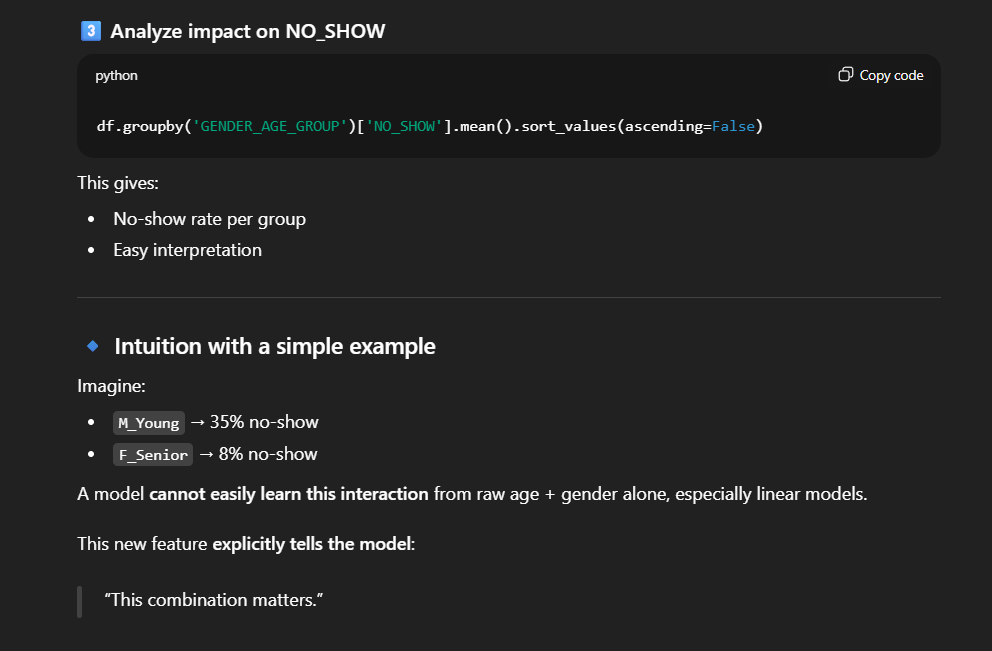  

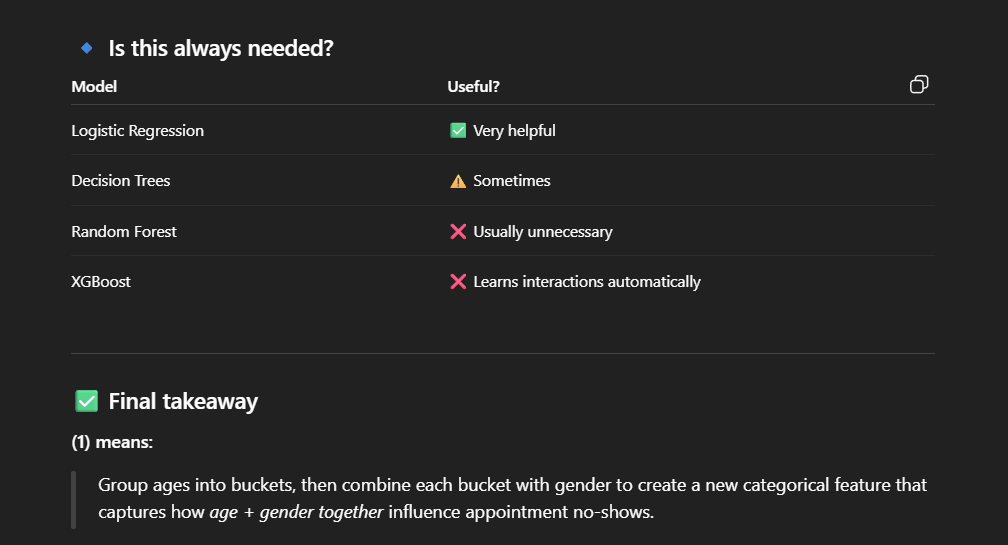   

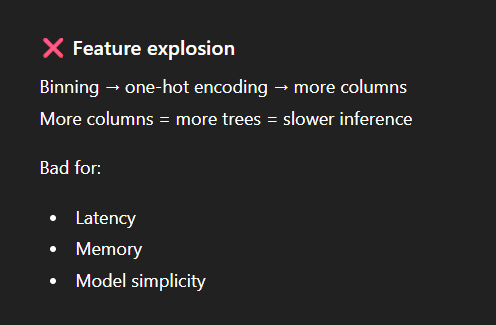  

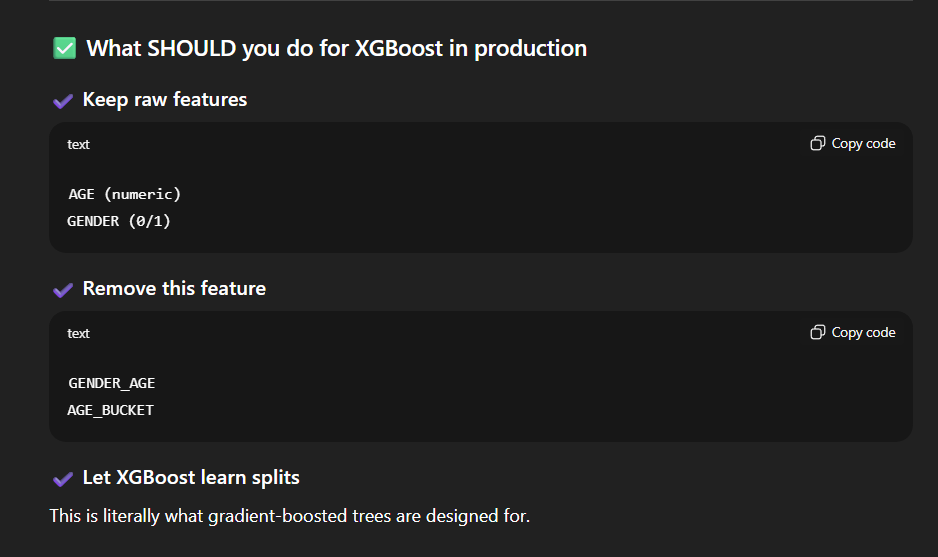  

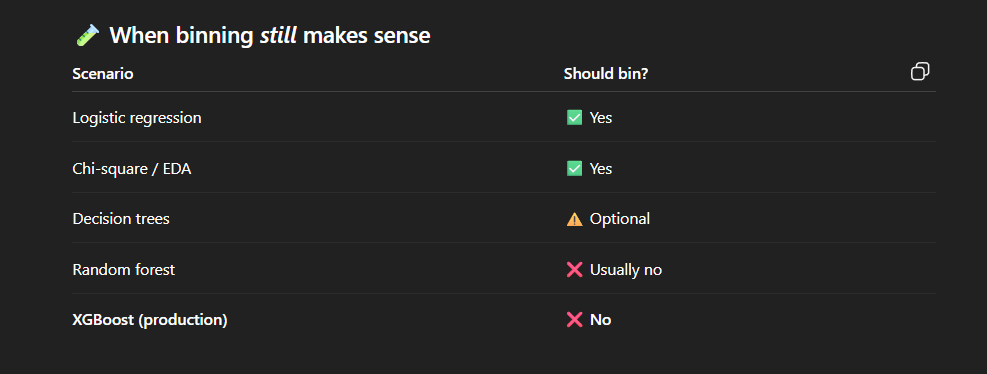  

#### 🔥 One-line truth

Binning + interaction features are for linear models and humans.  
XGBoost does not need them.

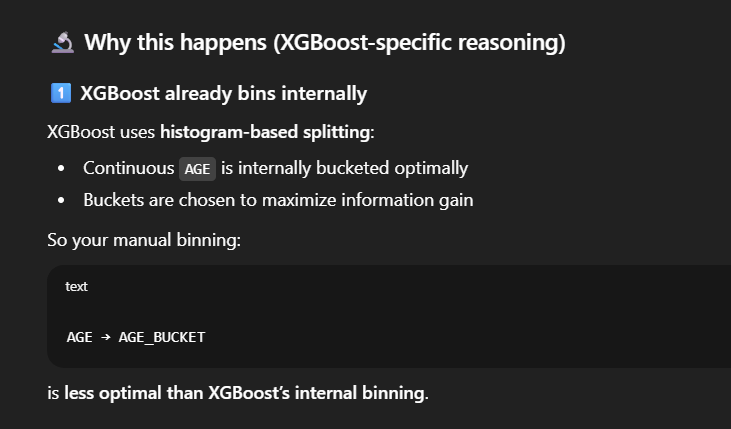

#### GENDER_AGE 
One of the key features we will create is *GENDER_AGE*, a combined feature of *GENDER* and *AGE_BUCKET*. This new feature aims to capture the interaction between a patient's gender and age group, which could have a significant impact on whether they will show up for their medical appointment.

##### Combine gender and bucketized age
we will first create a temporary column called *AGE_BUCKET*, which bucketizes *Age* into age groups, then combine *Gender* and the *AGE_BUCKET* as *GENDER_AGE*, and finally drop the temporary *AGE_BUCKET* column.

In [86]:
bins = [0, 13, 18, 31, 51, np.inf]
labels = ['0-12', '13-17', '18-30', '31-50', '50+']

In [87]:
train_data.head(1)

,GENDER,SCHEDULEDDAY,APPOINTMENTDAY,AGE,NEIGHBOURHOOD,SCHOLARSHIP,HYPERTENSION,DIABETES,ALCOHOLISM,HANDICAP,SMS_RECEIVED,NO_SHOW
APPOINTMENTID,,,,,,,,,,,,
5560465,F,2016-04-08 09:01:47+00:00,2016-05-13 00:00:00+00:00,74,DO QUADRO,0,1,1,0,0,0,1


In [226]:
train_data.shape

(88416, 12)

In [99]:
import pandas as pd

ages_test = [5, 12,13, 17, 24, 35, 60, 80]
bins_test = [0, 13, 18, 65, 100]
labels_test = ['Child', 'Teen', 'Adult', 'Senior']

age_groups = pd.cut(ages_test, bins=bins_test, labels=labels_test, right=False)
# ages_test is a list of ages to be categorized.
# bins_test defines the edges of the age categories.
# labels_test provides the labels for each age category.
# right=False means that the bins are left-inclusive and right-exclusive.
print(age_groups)


for label, start, end in zip(labels_test, bins_test[:-1], bins_test[1:]):
    print(f"{label}: ages {start} to {end - 1}")



['Child', 'Child', 'Teen', 'Teen', 'Adult', 'Adult', 'Adult', 'Senior']
Categories (4, object): ['Child' < 'Teen' < 'Adult' < 'Senior']
Child: ages 0 to 12
Teen: ages 13 to 17
Adult: ages 18 to 64
Senior: ages 65 to 99


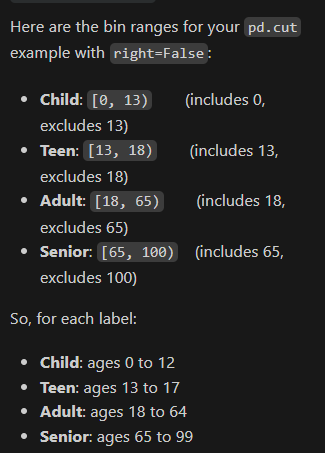

In [232]:
import pandas as pd

data_test = [12, 13, 17]
bins_test = [0, 13, 18]
print(pd.cut(data_test, bins=bins_test, right=True))   # (0, 13], (13, 18]
print(pd.cut(data_test, bins=bins_test, right=False))  # [0, 13), [13, 18)

[(0, 13], (0, 13], (13, 18]]
Categories (2, interval[int64, right]): [(0, 13] < (13, 18]]
[[0, 13), [13, 18), [13, 18)]
Categories (2, interval[int64, left]): [[0, 13) < [13, 18)]


In [100]:
bins = [0, 13, 18, 31, 51, np.inf]
labels = ['0-12', '13-17', '18-30', '31-50', '50+']

In [101]:
# Create AGE_BUCKET for training set and then create GENDER_AGE
# pd.cut is a pandas function used to segment and sort data values into discrete bins or intervals.
# It is commonly used to convert a continuous variable into a categorical variable by grouping values into specified ranges.
train_data['AGE_BUCKET'] = pd.cut(train_data['AGE'], bins=bins, labels=labels, right=False)
train_data['GENDER_AGE'] = train_data['GENDER'] + '_' + train_data['AGE_BUCKET'].astype(str)

In [106]:
train_data.tail(5)

,GENDER,SCHEDULEDDAY,APPOINTMENTDAY,AGE,NEIGHBOURHOOD,SCHOLARSHIP,HYPERTENSION,DIABETES,ALCOHOLISM,HANDICAP,SMS_RECEIVED,NO_SHOW,AGE_BUCKET,GENDER_AGE
APPOINTMENTID,,,,,,,,,,,,,,
5749761,M,2016-05-31 08:11:12+00:00,2016-05-31 00:00:00+00:00,45,ANDORINHAS,0,1,1,0,1,0,0,31-50,M_31-50
5743062,F,2016-05-30 08:39:18+00:00,2016-06-03 00:00:00+00:00,33,ITARARÉ,1,0,0,0,0,1,0,31-50,F_31-50
5738857,M,2016-05-25 11:46:36+00:00,2016-06-06 00:00:00+00:00,58,MÁRIO CYPRESTE,0,0,0,0,0,0,1,50+,M_50+
5693574,M,2016-05-13 07:26:13+00:00,2016-05-17 00:00:00+00:00,9,SANTO ANDRÉ,0,0,0,0,0,0,1,0-12,M_0-12
5668346,M,2016-05-06 08:53:43+00:00,2016-05-20 00:00:00+00:00,4,JESUS DE NAZARETH,0,0,0,0,0,0,0,0-12,M_0-12


In [107]:
train_data.shape

(88416, 14)

In [113]:
# Reorder columns to make 'NO_SHOW' the last column in train_data
cols_train = list(train_data.columns)
print(cols_train)
cols_train.remove('NO_SHOW')
print(cols_train)
cols_train.append('NO_SHOW')
print(cols_train)
train_data = train_data[cols_train]  

# Why it works? 
# It is selection + ordering at the same time.

['GENDER', 'SCHEDULEDDAY', 'APPOINTMENTDAY', 'AGE', 'NEIGHBOURHOOD', 'SCHOLARSHIP', 'HYPERTENSION', 'DIABETES', 'ALCOHOLISM', 'HANDICAP', 'SMS_RECEIVED', 'AGE_BUCKET', 'GENDER_AGE', 'NO_SHOW']
['GENDER', 'SCHEDULEDDAY', 'APPOINTMENTDAY', 'AGE', 'NEIGHBOURHOOD', 'SCHOLARSHIP', 'HYPERTENSION', 'DIABETES', 'ALCOHOLISM', 'HANDICAP', 'SMS_RECEIVED', 'AGE_BUCKET', 'GENDER_AGE']
['GENDER', 'SCHEDULEDDAY', 'APPOINTMENTDAY', 'AGE', 'NEIGHBOURHOOD', 'SCHOLARSHIP', 'HYPERTENSION', 'DIABETES', 'ALCOHOLISM', 'HANDICAP', 'SMS_RECEIVED', 'AGE_BUCKET', 'GENDER_AGE', 'NO_SHOW']


In [114]:
train_data.head(3)

,GENDER,SCHEDULEDDAY,APPOINTMENTDAY,AGE,NEIGHBOURHOOD,SCHOLARSHIP,HYPERTENSION,DIABETES,ALCOHOLISM,HANDICAP,SMS_RECEIVED,AGE_BUCKET,GENDER_AGE,NO_SHOW
APPOINTMENTID,,,,,,,,,,,,,,
5560465,F,2016-04-08 09:01:47+00:00,2016-05-13 00:00:00+00:00,74,DO QUADRO,0,1,1,0,0,0,50+,F_50+,1
5703645,F,2016-05-16 14:12:43+00:00,2016-05-17 00:00:00+00:00,61,DE LOURDES,0,0,0,0,0,0,50+,F_50+,1
5664960,F,2016-05-05 13:43:45+00:00,2016-05-19 00:00:00+00:00,21,SÃO JOSÉ,0,0,0,0,0,0,18-30,F_18-30,1


In [115]:
# Create AGE_BUCKET for testing set and then create GENDER_AGE
test_data['AGE_BUCKET'] = pd.cut(test_data['AGE'], bins=bins, labels=labels, right=False)
test_data['GENDER_AGE'] = test_data['GENDER'] + '_' + test_data['AGE_BUCKET'].astype(str)

In [116]:
# Reorder columns to make 'NO_SHOW' the last column in test_data
cols_test = list(test_data.columns)
cols_test.remove('NO_SHOW')
cols_test.append('NO_SHOW')
test_data = test_data[cols_test]

In [117]:
test_data.head(3)

,GENDER,SCHEDULEDDAY,APPOINTMENTDAY,AGE,NEIGHBOURHOOD,SCHOLARSHIP,HYPERTENSION,DIABETES,ALCOHOLISM,HANDICAP,SMS_RECEIVED,AGE_BUCKET,GENDER_AGE,NO_SHOW
APPOINTMENTID,,,,,,,,,,,,,,
5583315,F,2016-04-14 10:50:00+00:00,2016-05-02 00:00:00+00:00,53,BONFIM,0,0,0,0,0,1,50+,F_50+,1
5725340,F,2016-05-20 10:56:58+00:00,2016-05-24 00:00:00+00:00,60,CONQUISTA,0,1,1,0,0,1,50+,F_50+,0
5691555,F,2016-05-12 13:10:24+00:00,2016-06-01 00:00:00+00:00,8,RESISTÊNCIA,0,0,0,0,0,1,0-12,F_0-12,0


In [118]:
# Drop AGE_BUCKET from training set
train_data.drop('AGE_BUCKET', axis=1, inplace=True) # axis=1 indicates column

# Drop AGE_BUCKET from testing set
test_data.drop('AGE_BUCKET', axis=1, inplace=True)

In [119]:
test_data.head(3)

,GENDER,SCHEDULEDDAY,APPOINTMENTDAY,AGE,NEIGHBOURHOOD,SCHOLARSHIP,HYPERTENSION,DIABETES,ALCOHOLISM,HANDICAP,SMS_RECEIVED,GENDER_AGE,NO_SHOW
APPOINTMENTID,,,,,,,,,,,,,
5583315,F,2016-04-14 10:50:00+00:00,2016-05-02 00:00:00+00:00,53,BONFIM,0,0,0,0,0,1,F_50+,1
5725340,F,2016-05-20 10:56:58+00:00,2016-05-24 00:00:00+00:00,60,CONQUISTA,0,1,1,0,0,1,F_50+,0
5691555,F,2016-05-12 13:10:24+00:00,2016-06-01 00:00:00+00:00,8,RESISTÊNCIA,0,0,0,0,0,1,F_0-12,0


In [120]:
# Check the shape of the training set
print(f"Shape of training set: {train_data.shape}")

# Check the shape of the testing set
print(f"Shape of testing set: {test_data.shape}")

Shape of training set: (88416, 13)
Shape of testing set: (22105, 13)


##### Chi-Square Test: GENDER_AGE and No-Show
**Objective**<br>
To understand if the combined feature of gender and age group has a significant impact on the likelihood of a patient missing their appointment.

**Null Hypothesis (H0)**<br>
There is no significant relationship between *GENDER_AGE* and *NO_SHOW*.

**Alternative Hypothesis (H1)**<br>
There is a significant relationship between *GENDER_AGE* and *NO_SHOW*.

**Significance Level**<br>
We will use a significance level ($\alpha$) of 0.05 for this test.
    
**Expected Outcome**<br>
If the p-value obtained from the Chi-Square Test is less than the significance level, we will reject the null hypothesis, indicating that *GENDER_AGE* has a significant impact on *NO_SHOW*. Otherwise, we fail to reject the null hypothesis.

We will only perform the statistical tests on the training set. This is because the training set is what we'll be using to build our model, and we want to understand the relationships within that specific subset of the data.    

We only perform statistical tests on the training set to understand relationships used for model building, and we keep the test set untouched to preserve its integrity for evaluation.   

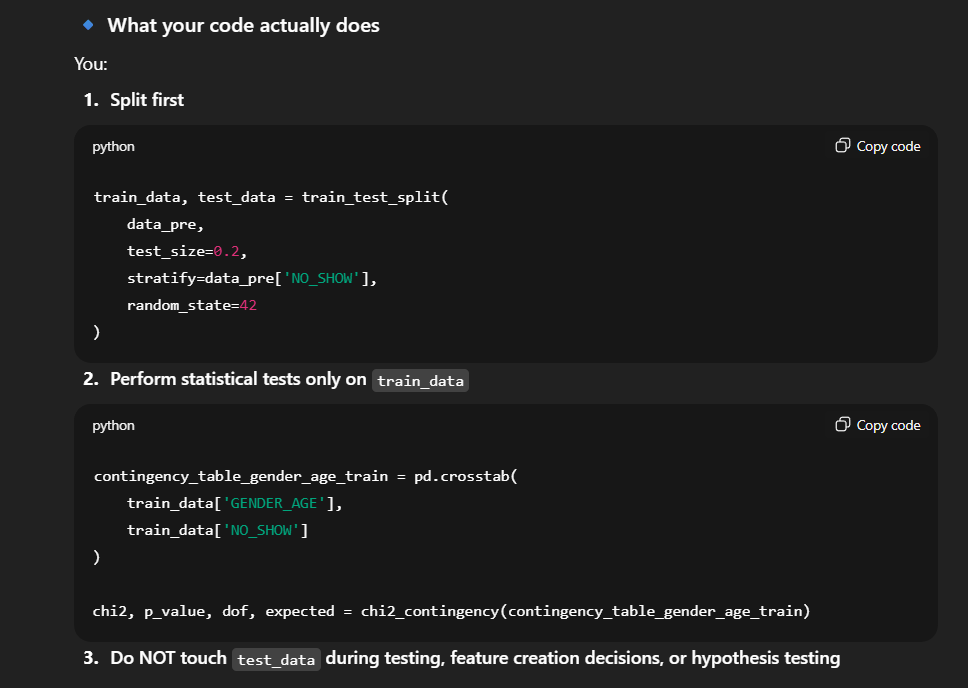   

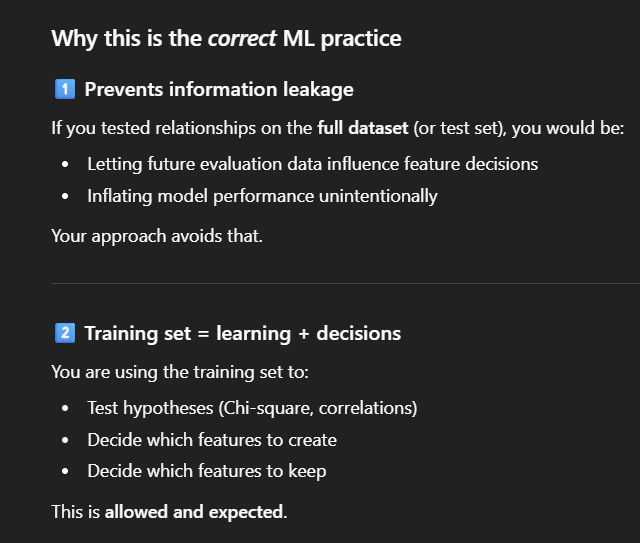   

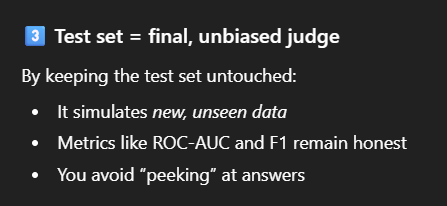  

Statistical tests are exploratory, not part of model training.  


Additionally, keeping the test set untouched ensures its integrity for model evaluation later on.   

We perform statistical tests on the training set to guide feature engineering and understanding of relationships, while keeping the test set untouched to ensure unbiased evaluation.    


#### Inflated metrics = numbers that look better than they truly are.   

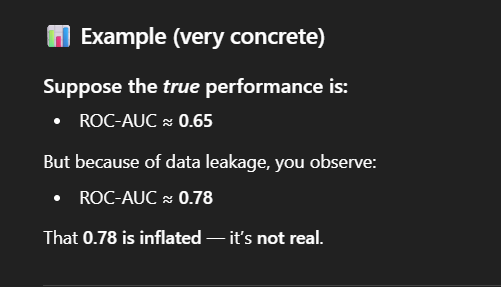

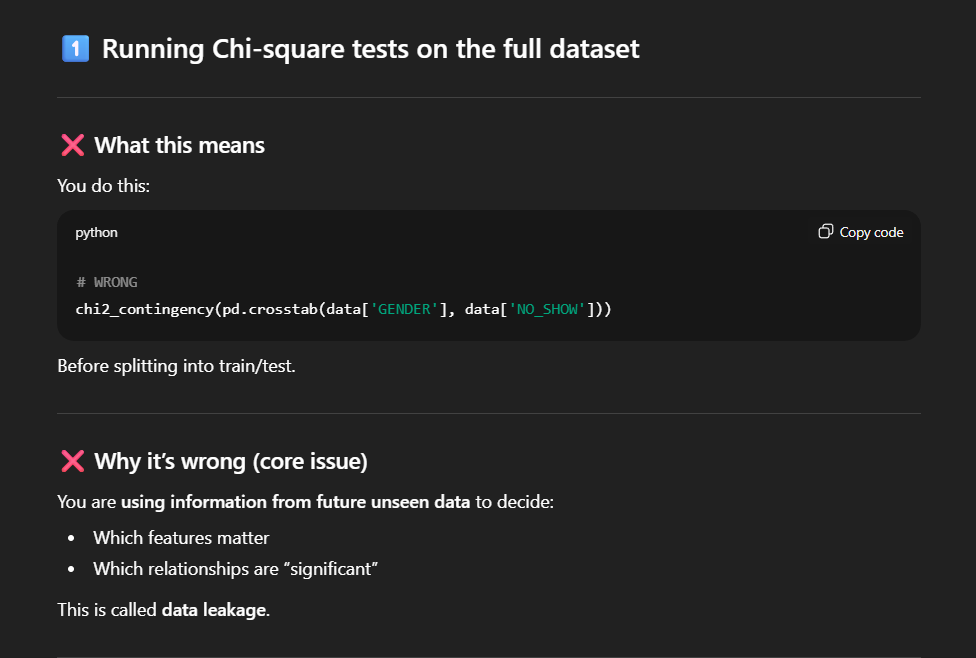   

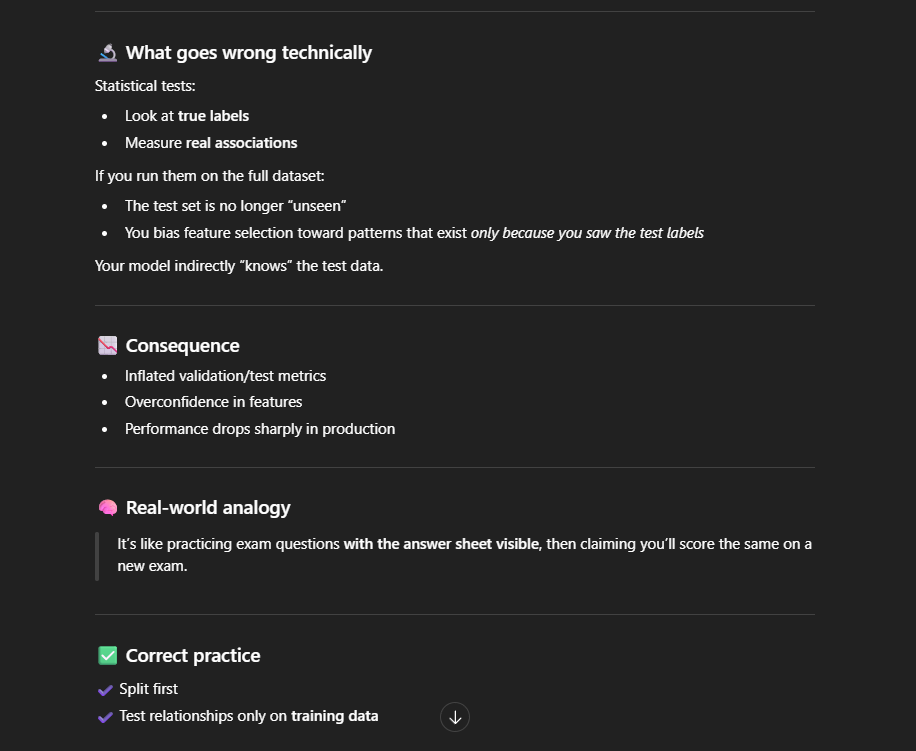  

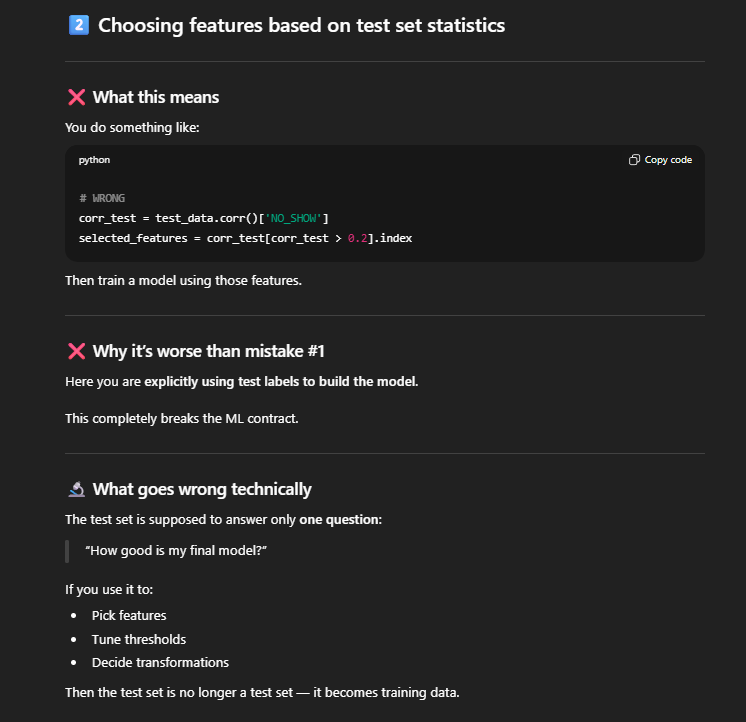   

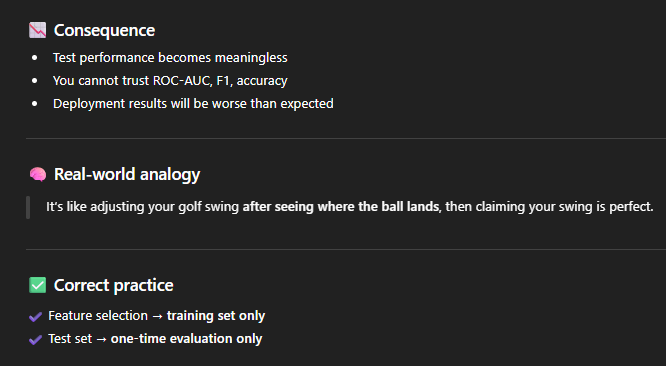   

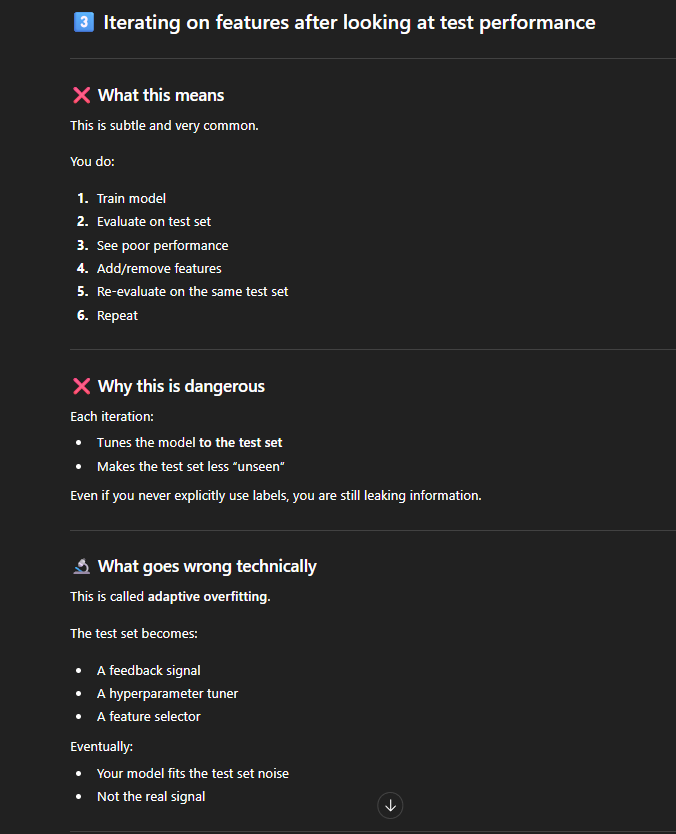  

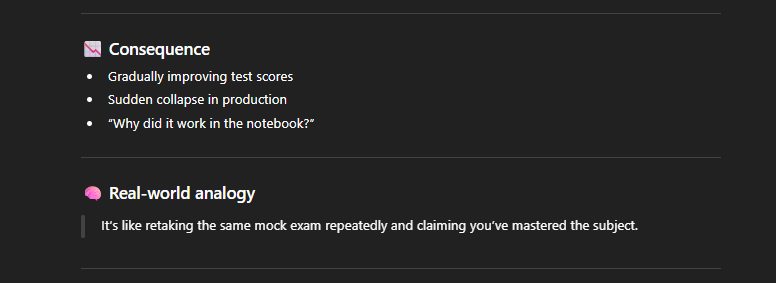  

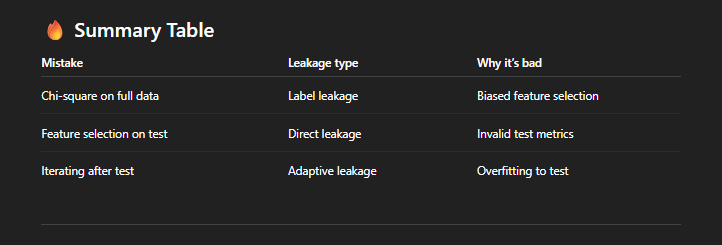  

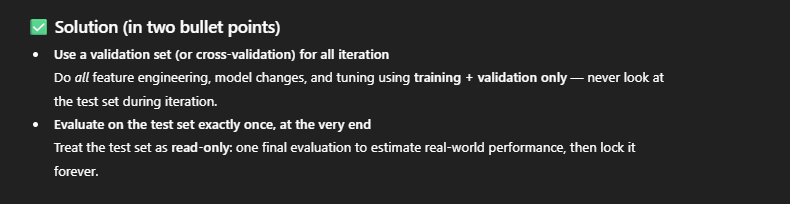  

#### Iterate on validation, evaluate once on test.   

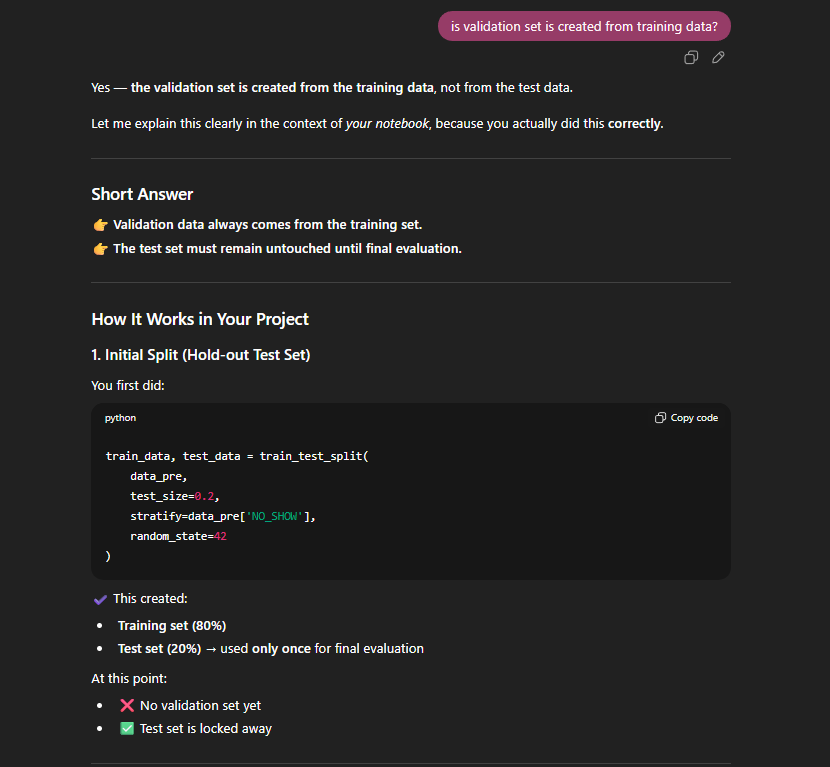  

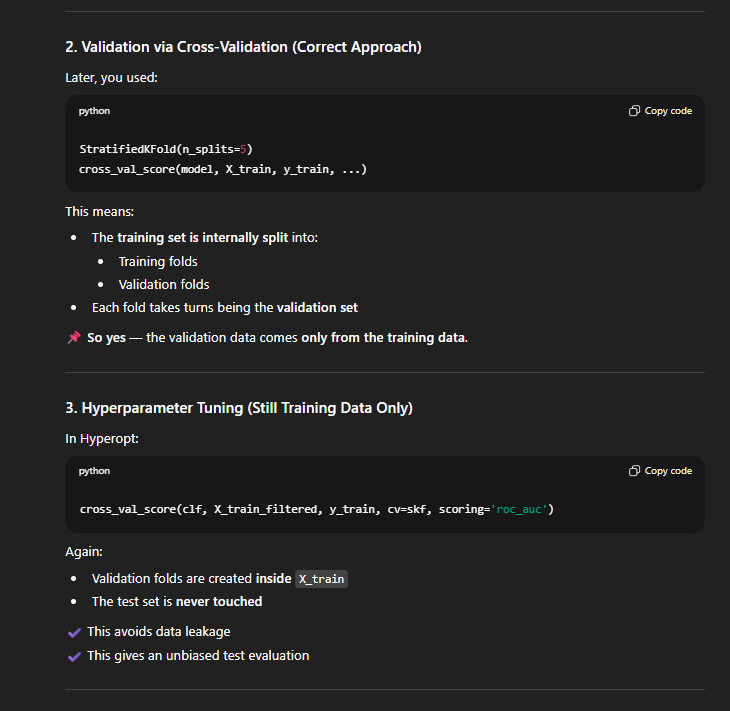  

#### The validation set is created from the training data, typically via cross-validation, while the test set is kept completely unseen until final evaluation.


In [121]:
# Create the contingency table for GENDER_AGE and NO_SHOW in the training set
contingency_table_gender_age_train = pd.crosstab(train_data['GENDER_AGE'], train_data['NO_SHOW'])
contingency_table_gender_age_train

NO_SHOW,0,1
GENDER_AGE,,
F_0-12,6395,1649
F_13-17,2281,820
F_18-30,8102,2692
F_31-50,13021,3403
F_50+,16045,3155
M_0-12,6924,1796
M_13-17,1441,552
M_18-30,2910,927
M_31-50,5728,1466


In [124]:
train_data.head()

,GENDER,SCHEDULEDDAY,APPOINTMENTDAY,AGE,NEIGHBOURHOOD,SCHOLARSHIP,HYPERTENSION,DIABETES,ALCOHOLISM,HANDICAP,SMS_RECEIVED,GENDER_AGE,NO_SHOW
APPOINTMENTID,,,,,,,,,,,,,
5560465,F,2016-04-08 09:01:47+00:00,2016-05-13 00:00:00+00:00,74,DO QUADRO,0,1,1,0,0,0,F_50+,1
5703645,F,2016-05-16 14:12:43+00:00,2016-05-17 00:00:00+00:00,61,DE LOURDES,0,0,0,0,0,0,F_50+,1
5664960,F,2016-05-05 13:43:45+00:00,2016-05-19 00:00:00+00:00,21,SÃO JOSÉ,0,0,0,0,0,0,F_18-30,1
5715065,M,2016-05-18 13:35:45+00:00,2016-06-07 00:00:00+00:00,7,INHANGUETÁ,0,0,0,0,0,1,M_0-12,0
5583311,F,2016-04-14 10:49:16+00:00,2016-05-20 00:00:00+00:00,6,MARIA ORTIZ,0,0,0,0,0,0,F_0-12,0


In [122]:
# Perform the Chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table_gender_age_train)

# Print the results
print("Results")
print(f"Chi-square value: {chi2}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")

# Interpret the results
alpha = 0.05  # Significance level
print("\nConclusion")
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant relationship between GENDER_AGE and No-show in the training set.")
else:
    print("Fail to reject the null hypothesis. There is no significant relationship between GENDER_AGE and No-show in the training set.")

Results
Chi-square value: 643.0436220257102
P-value: 1.2000036012596083e-132
Degrees of Freedom: 9

Conclusion
Reject the null hypothesis. There is a significant relationship between GENDER_AGE and No-show in the training set.


#### DAYS_TILL_APPOINTMENT
In this section, we introduce a new feature called *DAYS_TILL_APPOINTMENT*, which represents the number of days between the scheduled day and the actual appointment day. This feature could potentially help us understand if the time gap between scheduling and the appointment has any impact on the likelihood of a patient missing their appointment.

##### Subtract scheduled day from appointment day
Create a new feature *DAYS_TILL_APPOINTMENT* by subtracting scheduled day from appointment day.

In [125]:
# Calculate the number of days till the appointment for both training sets
train_data['DAYS_TILL_APPOINTMENT'] = (train_data['APPOINTMENTDAY'] - train_data['SCHEDULEDDAY']).dt.days + 1

In [126]:
train_data.head(3)

,GENDER,SCHEDULEDDAY,APPOINTMENTDAY,AGE,NEIGHBOURHOOD,SCHOLARSHIP,HYPERTENSION,DIABETES,ALCOHOLISM,HANDICAP,SMS_RECEIVED,GENDER_AGE,NO_SHOW,DAYS_TILL_APPOINTMENT
APPOINTMENTID,,,,,,,,,,,,,,
5560465,F,2016-04-08 09:01:47+00:00,2016-05-13 00:00:00+00:00,74,DO QUADRO,0,1,1,0,0,0,F_50+,1,35
5703645,F,2016-05-16 14:12:43+00:00,2016-05-17 00:00:00+00:00,61,DE LOURDES,0,0,0,0,0,0,F_50+,1,1
5664960,F,2016-05-05 13:43:45+00:00,2016-05-19 00:00:00+00:00,21,SÃO JOSÉ,0,0,0,0,0,0,F_18-30,1,14


In [127]:
# Reorder columns to make 'NO_SHOW' the last column in train_data
cols_train = list(train_data.columns)
cols_train.remove('NO_SHOW')
cols_train.append('NO_SHOW')
train_data = train_data[cols_train]

In [128]:
train_data.head(3)

,GENDER,SCHEDULEDDAY,APPOINTMENTDAY,AGE,NEIGHBOURHOOD,SCHOLARSHIP,HYPERTENSION,DIABETES,ALCOHOLISM,HANDICAP,SMS_RECEIVED,GENDER_AGE,DAYS_TILL_APPOINTMENT,NO_SHOW
APPOINTMENTID,,,,,,,,,,,,,,
5560465,F,2016-04-08 09:01:47+00:00,2016-05-13 00:00:00+00:00,74,DO QUADRO,0,1,1,0,0,0,F_50+,35,1
5703645,F,2016-05-16 14:12:43+00:00,2016-05-17 00:00:00+00:00,61,DE LOURDES,0,0,0,0,0,0,F_50+,1,1
5664960,F,2016-05-05 13:43:45+00:00,2016-05-19 00:00:00+00:00,21,SÃO JOSÉ,0,0,0,0,0,0,F_18-30,14,1


In [129]:
# Calculate the number of days till the appointment for test sets
test_data['DAYS_TILL_APPOINTMENT'] = (test_data['APPOINTMENTDAY'] - test_data['SCHEDULEDDAY']).dt.days + 1

In [132]:
# Reorder columns to make 'NO_SHOW' the last column in train_data
cols_train = list(test_data.columns)
cols_train.remove('NO_SHOW')
cols_train.append('NO_SHOW')
test_data = test_data[cols_train]

In [133]:
test_data.head(3)

,GENDER,SCHEDULEDDAY,APPOINTMENTDAY,AGE,NEIGHBOURHOOD,SCHOLARSHIP,HYPERTENSION,DIABETES,ALCOHOLISM,HANDICAP,SMS_RECEIVED,GENDER_AGE,DAYS_TILL_APPOINTMENT,NO_SHOW
APPOINTMENTID,,,,,,,,,,,,,,
5583315,F,2016-04-14 10:50:00+00:00,2016-05-02 00:00:00+00:00,53,BONFIM,0,0,0,0,0,1,F_50+,18,1
5725340,F,2016-05-20 10:56:58+00:00,2016-05-24 00:00:00+00:00,60,CONQUISTA,0,1,1,0,0,1,F_50+,4,0
5691555,F,2016-05-12 13:10:24+00:00,2016-06-01 00:00:00+00:00,8,RESISTÊNCIA,0,0,0,0,0,1,F_0-12,20,0


Let's verify there's no negative days till appointment and check out the shapes of all available datasets to confirm our operations.

In [134]:
# Check for negative values in the 'DAYS_TILL_APPOINTMENT' column
negative_days = train_data[train_data['DAYS_TILL_APPOINTMENT'] < 0]

# Print out the number of rows with negative days
print(f"Number of rows with negative 'DAYS_TILL_APPOINTMENT': {len(negative_days)}")

Number of rows with negative 'DAYS_TILL_APPOINTMENT': 0


In [135]:
# Check the shape of the training set
print(f"Shape of training set: {train_data.shape}")

# Check the shape of the testing set
print(f"Shape of testing set: {test_data.shape}")

Shape of training set: (88416, 14)
Shape of testing set: (22105, 14)


##### Point-Biserial Correlation: DAYS_TILL_APPOINTMENT and No-Show   

#### We use Point-Biserial Correlation for DAYS_TILL_APPOINTMENT because it is a continuous (or ordinal-numeric) feature → binary target relationship. Chi-square is appropriate when both variables are categorical.


**Objective**<br>
To evaluate the impact of the feature *DAYS_TILL_APPOINTMENT* on the target variable *NO_SHOW*.

**Null Hypothesis (H0)**<br>
There is no relationship between *DAYS_TILL_APPOINTMENT* and *NO_SHOW*.

**Alternative Hypothesis (H1)**<br>
There is a relationship between *DAYS_TILL_APPOINTMENT* and *NO_SHOW*.

**Significance Level ($\alpha$)**<br>
0.05

**Expected Outcome**<br>
If the p-value is less than the significance level, we reject the null hypothesis.

In [ ]:
# Calculate the Point-Biserial Correlation Coefficient
result = pointbiserialr(train_data['DAYS_TILL_APPOINTMENT'], train_data['NO_SHOW'])

In [ ]:
# Print the results
print("Point-Biserial Correlation Coefficient:", result.correlation)
print("P-value:", result.pvalue)

# Interpret the results
alpha = 0.05  # Significance level
print("\nConclusion")
if result.pvalue < alpha:
    print(f"Reject the null hypothesis. There is a significant relationship between DAYS_TILL_APPOINTMENT and NO_SHOW with a correlation coefficient of {result.correlation}.")
else:
    print("Fail to reject the null hypothesis. There is no significant relationship between DAYS_TILL_APPOINTMENT and NO_SHOW.")

Point-Biserial Correlation Coefficient: 0.18423560605462125
P-value: 0.0

Conclusion
Reject the null hypothesis. There is a significant relationship between DAYS_TILL_APPOINTMENT and NO_SHOW with a correlation coefficient of 0.18423560605462125.


**Observation**

A Point-Biserial Correlation Coefficient of 0.184 suggests a low but positive correlation between *DAYS_TILL_APPOINTMENT* and *NO_SHOW*. This means that as the number of days until the appointment increases, the likelihood of a no-show also slightly increases. However, the relationship is not strong.

### Preprocess dateetime columns
After creating the two new features, we continue to implement additional preprocessing steps. We focus on two key tasks: first, the extraction of meaningful features from datetime columns, and second, the removal of features that do not provide valuable information for our models.

#### Extract year, month, and day from SCHEDULEDDAY and APPOINTMENTDAY
In our dataset, we have two datetime columns: *SCHEDULEDDAY* and *APPOINTMENTDAY*. Machine learning models require numerical or categorical data, so we need to convert these datetime columns into a format that the model can understand. We'll extract the year, month, and day as separate features for each of these columns.

In [ ]:
# List of all datasets
datasets = [train_data, test_data]

# Loop through each dataset to perform the datetime feature extraction
for dataset in datasets:
    # Extracting year, month, and day from SCHEDULEDDAY
    dataset['SCHEDULEDDAY_YEAR'] = dataset['SCHEDULEDDAY'].dt.year
    dataset['SCHEDULEDDAY_MONTH'] = dataset['SCHEDULEDDAY'].dt.month
    dataset['SCHEDULEDDAY_DAY'] = dataset['SCHEDULEDDAY'].dt.day

    # Extracting year, month, and day from APPOINTMENTDAY
    dataset['APPOINTMENTDAY_YEAR'] = dataset['APPOINTMENTDAY'].dt.year
    dataset['APPOINTMENTDAY_MONTH'] = dataset['APPOINTMENTDAY'].dt.month
    dataset['APPOINTMENTDAY_DAY'] = dataset['APPOINTMENTDAY'].dt.day

    # Dropping the original datetime columns
    dataset.drop(['SCHEDULEDDAY', 'APPOINTMENTDAY'], axis=1, inplace=True)

# Reorder columns to make 'NO_SHOW' the last column in train_data
cols_train = list(train_data.columns)
cols_train.remove('NO_SHOW')
cols_train.append('NO_SHOW')
train_data = train_data[cols_train]

# Reorder columns to make 'NO_SHOW' the last column in test_data
cols_test = list(test_data.columns)
cols_test.remove('NO_SHOW')
cols_test.append('NO_SHOW')
test_data = test_data[cols_test]

Let's check out the shapes of all available datasets to confirm our operations.

In [ ]:
# Check the shape of the training set
print(f"Shape of training set: {train_data.shape}")

# Check the shape of the testing set
print(f"Shape of testing set: {test_data.shape}")

Shape of training set: (88416, 18)
Shape of testing set: (22105, 18)


Before extracting we have 14 columns, we added 6 columns of schedule day's and appointment day's of day, month, year then drop the orginal *SCHEDULEDDAY* and *APPOINTMENTDAY* therefore 14+6-2=18.

#### Delete year column with just one unique value
If all the years are the same in a particular column, then that feature likely won't provide any useful information for the model. In that case, we can safely drop it.

In [ ]:
# List of all datasets
datasets = [train_data, test_data]

# Columns to check for unique values
year_columns_to_check = ['SCHEDULEDDAY_YEAR', 'APPOINTMENTDAY_YEAR']

# Loop through each dataset
for dataset in datasets:
    for col in year_columns_to_check:
        # If the column has only one unique value, drop it
        if dataset[col].nunique() == 1:
            print(f"Dropping {col} as it has only one unique value.")
            dataset.drop([col], axis=1, inplace=True)

Dropping APPOINTMENTDAY_YEAR as it has only one unique value.
Dropping APPOINTMENTDAY_YEAR as it has only one unique value.


Let's check out the shapes of all available datasets to confirm our operations.

In [ ]:
# Check the shape of the training set
print(f"Shape of training set: {train_data.shape}")

# Check the shape of the testing set
print(f"Shape of testing set: {test_data.shape}")

Shape of training set: (88416, 17)
Shape of testing set: (22105, 17)


We dropped *APPOINTMENTDAY_YEAR*.

### Numeric encode categorical features
In this section, we will encode the categorical features *GENDER*, *NEIGHBOURHOOD*, and *GENDER_AGE* to prepare them for machine learning algorithms. Different encoding techniques will be applied based on the nature and distribution of each categorical variable.

Let's first verify our which columns are categorical and their corresponding total unique values.

In [ ]:
# Identify categorical columns in the training set
categorical_columns = train_data.select_dtypes(include=['object']).columns.tolist()

# Print the categorical columns
print("Categorical Columns:", categorical_columns)

Categorical Columns: ['GENDER', 'NEIGHBOURHOOD', 'GENDER_AGE']


In [ ]:
# Check the number of unique values in each categorical column in training set
print("Training data unique values count for Categorical Columns:")
for col in ['GENDER', 'NEIGHBOURHOOD', 'GENDER_AGE']:
    print(f"{col} has {train_data[col].nunique()} unique values.")

Training data unique values count for Categorical Columns:
GENDER has 2 unique values.
NEIGHBOURHOOD has 81 unique values.
GENDER_AGE has 10 unique values.


In [ ]:
# Check the number of unique values in each categorical column in test set
print("Test data unique values count for Categorical Columns:")
for col in ['GENDER', 'NEIGHBOURHOOD', 'GENDER_AGE']:
    print(f"{col} has {test_data[col].nunique()} unique values.")

Test data unique values count for Categorical Columns:
GENDER has 2 unique values.
NEIGHBOURHOOD has 78 unique values.
GENDER_AGE has 10 unique values.


#### Encode GENDER
Since *GENDER* is a binary categorical feature, we will map 'Male' to 1 and 'Female' to 0. This is a straightforward method that avoids adding extra dimensions to our dataset.

In [ ]:
# Encoding the 'GENDER' column for the original training set
train_data['GENDER'] = train_data['GENDER'].map({'M': 1, 'F': 0})

# Encoding the 'GENDER' column for the test set
test_data['GENDER'] = test_data['GENDER'].map({'M': 1, 'F': 0})

Let's check out the unique values for *GENDER* to confirm our operations.

In [ ]:
# Check the unique values in the 'GENDER' column for the training set
unique_values_train = train_data['GENDER'].unique()
print(f"Unique values in 'GENDER' column for training set: {unique_values_train}")

# Check the unique values in the 'GENDER' column for the test set
unique_values_test = test_data['GENDER'].unique()
print(f"Unique values in 'GENDER' column for test set: {unique_values_test}")

Unique values in 'GENDER' column for training set: [0 1]
Unique values in 'GENDER' column for test set: [0 1]


#### Encode GENDER_AGE
For *GENDER_AGE*, we will use one-hot encoding. This feature has a moderate number of unique values, making one-hot encoding a suitable choice.

In [ ]:
# One-hot encode 'GENDER_AGE' for all datasets
train_data = pd.get_dummies(train_data, columns=['GENDER_AGE'], drop_first=True, dtype=int)
test_data = pd.get_dummies(test_data, columns=['GENDER_AGE'], drop_first=True, dtype=int)

In [ ]:
# Reorder columns to make 'NO_SHOW' the last column in train_data
cols_train = list(train_data.columns)
cols_train.remove('NO_SHOW')
cols_train.append('NO_SHOW')
train_data = train_data[cols_train]

# Reorder columns to make 'NO_SHOW' the last column in test_data
cols_test = list(test_data.columns)
cols_test.remove('NO_SHOW')
cols_test.append('NO_SHOW')
test_data = test_data[cols_test]

Let's have a look at the data frames to confirm our operations.

In [ ]:
# Check the first few rows of the training set to see the new columns
print("First few rows of training data:")
display(train_data.head())

# Check the first few rows of the test set to see the new columns
print("\nFirst few rows of test data:")
display(test_data.head())

# Check if all data types of the new columns in the training set are integers
print("\nAre all new columns in training data of integer type?")
print(all(train_data.filter(like='GENDER_AGE').dtypes == 'int'))

# Check if all data types of the new columns in the test set are integers
print("\nAre all new columns in test data of integer type?")
print(all(test_data.filter(like='GENDER_AGE').dtypes == 'int'))

# Check that both datasets have the same columns in the same order after encoding
print("\nDo both datasets have the same columns in the same order after encoding?")
print(list(train_data.columns) == list(test_data.columns))

First few rows of training data:


,GENDER,AGE,NEIGHBOURHOOD,SCHOLARSHIP,HIPERTENSION,DIABETES,ALCOHOLISM,HANDCAP,SMS_RECEIVED,DAYS_TILL_APPOINTMENT,...,GENDER_AGE_F_13-17,GENDER_AGE_F_18-30,GENDER_AGE_F_31-50,GENDER_AGE_F_50+,GENDER_AGE_M_0-12,GENDER_AGE_M_13-17,GENDER_AGE_M_18-30,GENDER_AGE_M_31-50,GENDER_AGE_M_50+,NO_SHOW
APPOINTMENTID,,,,,,,,,,,,,,,,,,,,,
5560465,0,74,DO QUADRO,0,1,1,0,0,0,35,...,0,0,0,1,0,0,0,0,0,1
5703645,0,61,DE LOURDES,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
5664960,0,21,SÃO JOSÉ,0,0,0,0,0,0,14,...,0,1,0,0,0,0,0,0,0,1
5715065,1,7,INHANGUETÁ,0,0,0,0,0,1,20,...,0,0,0,0,1,0,0,0,0,0
5583311,0,6,MARIA ORTIZ,0,0,0,0,0,0,36,...,0,0,0,0,0,0,0,0,0,0



First few rows of test data:


,GENDER,AGE,NEIGHBOURHOOD,SCHOLARSHIP,HIPERTENSION,DIABETES,ALCOHOLISM,HANDCAP,SMS_RECEIVED,DAYS_TILL_APPOINTMENT,...,GENDER_AGE_F_13-17,GENDER_AGE_F_18-30,GENDER_AGE_F_31-50,GENDER_AGE_F_50+,GENDER_AGE_M_0-12,GENDER_AGE_M_13-17,GENDER_AGE_M_18-30,GENDER_AGE_M_31-50,GENDER_AGE_M_50+,NO_SHOW
APPOINTMENTID,,,,,,,,,,,,,,,,,,,,,
5583315,0,53,BONFIM,0,0,0,0,0,1,18,...,0,0,0,1,0,0,0,0,0,1
5725340,0,60,CONQUISTA,0,1,1,0,0,1,4,...,0,0,0,1,0,0,0,0,0,0
5691555,0,8,RESISTÊNCIA,0,0,0,0,0,1,20,...,0,0,0,0,0,0,0,0,0,0
5631368,1,64,CENTRO,0,0,0,0,0,1,12,...,0,0,0,0,0,0,0,0,1,0
5682650,0,34,JARDIM CAMBURI,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0



Are all new columns in training data of integer type?
True

Are all new columns in test data of integer type?
True

Do both datasets have the same columns in the same order after encoding?
True


**Observations**
- Before encoding: 17 columns
- GENDER_AGE (One-Hot Encoded but with `drop_first=True`): +9 columns

17 originals columns + 9 new columns = 26 total columns.<br>
Since the original *GENDER_AGE* column will be dropped, therefore we have 26  - 1 = 25 total columns.

#### Encode NEIGHBOURHOOD
*NEIGHBOURHOOD* has a high cardinality. To handle this, we will use target encoding. This method will help us capture the relationship between the neighborhood and the target variable, *NO_SHOW*.

In [ ]:
# Target encode 'NEIGHBOURHOOD' for all datasets
encoder = TargetEncoder()
train_data['NEIGHBOURHOOD'] = encoder.fit_transform(train_data['NEIGHBOURHOOD'], train_data['NO_SHOW'])
test_data['NEIGHBOURHOOD'] = encoder.transform(test_data['NEIGHBOURHOOD'])

Let's check for missing values, unique values, and data types of all available datasets to confirm our operations.

In [ ]:
# Check the data type of the 'NEIGHBOURHOOD' column in both datasets
print("Data type in training data:", train_data['NEIGHBOURHOOD'].dtype)
print("Data type in test data:", test_data['NEIGHBOURHOOD'].dtype)

# Check for missing values in the 'NEIGHBOURHOOD' column in both datasets
print("Missing values in training data:", train_data['NEIGHBOURHOOD'].isnull().sum())
print("Missing values in test data:", test_data['NEIGHBOURHOOD'].isnull().sum())

# Check the number of unique values in the 'NEIGHBOURHOOD' column in both datasets
print("Unique values in training data:", train_data['NEIGHBOURHOOD'].nunique())
print("Unique values in test data:", test_data['NEIGHBOURHOOD'].nunique())

Data type in training data: float64
Data type in test data: float64
Missing values in training data: 0
Missing values in test data: 0
Unique values in training data: 81
Unique values in test data: 78


**Observations**
1. **Data Types**: Both the training and test datasets have the *NEIGHBOURHOOD* column as `float64`, which is a numerical data type. This is expected after target encoding.
  
2. **Missing Values**: There are no missing values in the *NEIGHBOURHOOD* column for both datasets, which is a good sign.

3. **Unique Values**: The number of unique values in the training data is 81 and in the test data is 78. This is expected behavior, as target encoding will map each unique category to a different numerical value based on the mean of the target variable for that category.

After all the encodings are done, there should be no categorical columns left.

In [ ]:
# Check if there are any non-numeric columns in each dataset
print("Number of non-numeric columns in the original training set:", len(train_data.select_dtypes(exclude=['number']).columns))
print("Number of non-numeric columns in the test set:", len(test_data.select_dtypes(exclude=['number']).columns))

Number of non-numeric columns in the original training set: 0
Number of non-numeric columns in the test set: 0


### Feature Correlation Analysis
In this section, we analyze the correlations between different features to identify any significant multicollinearity which could impact the performance of certain predictive models (such as logistic regression). A correlation matrix is computed and visualized as a heatmap for an intuitive understanding of these relationships. We particularly focus on identifying very high correlations (coefficients > 0.8 or < -0.8) as indicators of multicollinearity. The outcomes of this analysis will inform subsequent feature selection and modeling decisions.

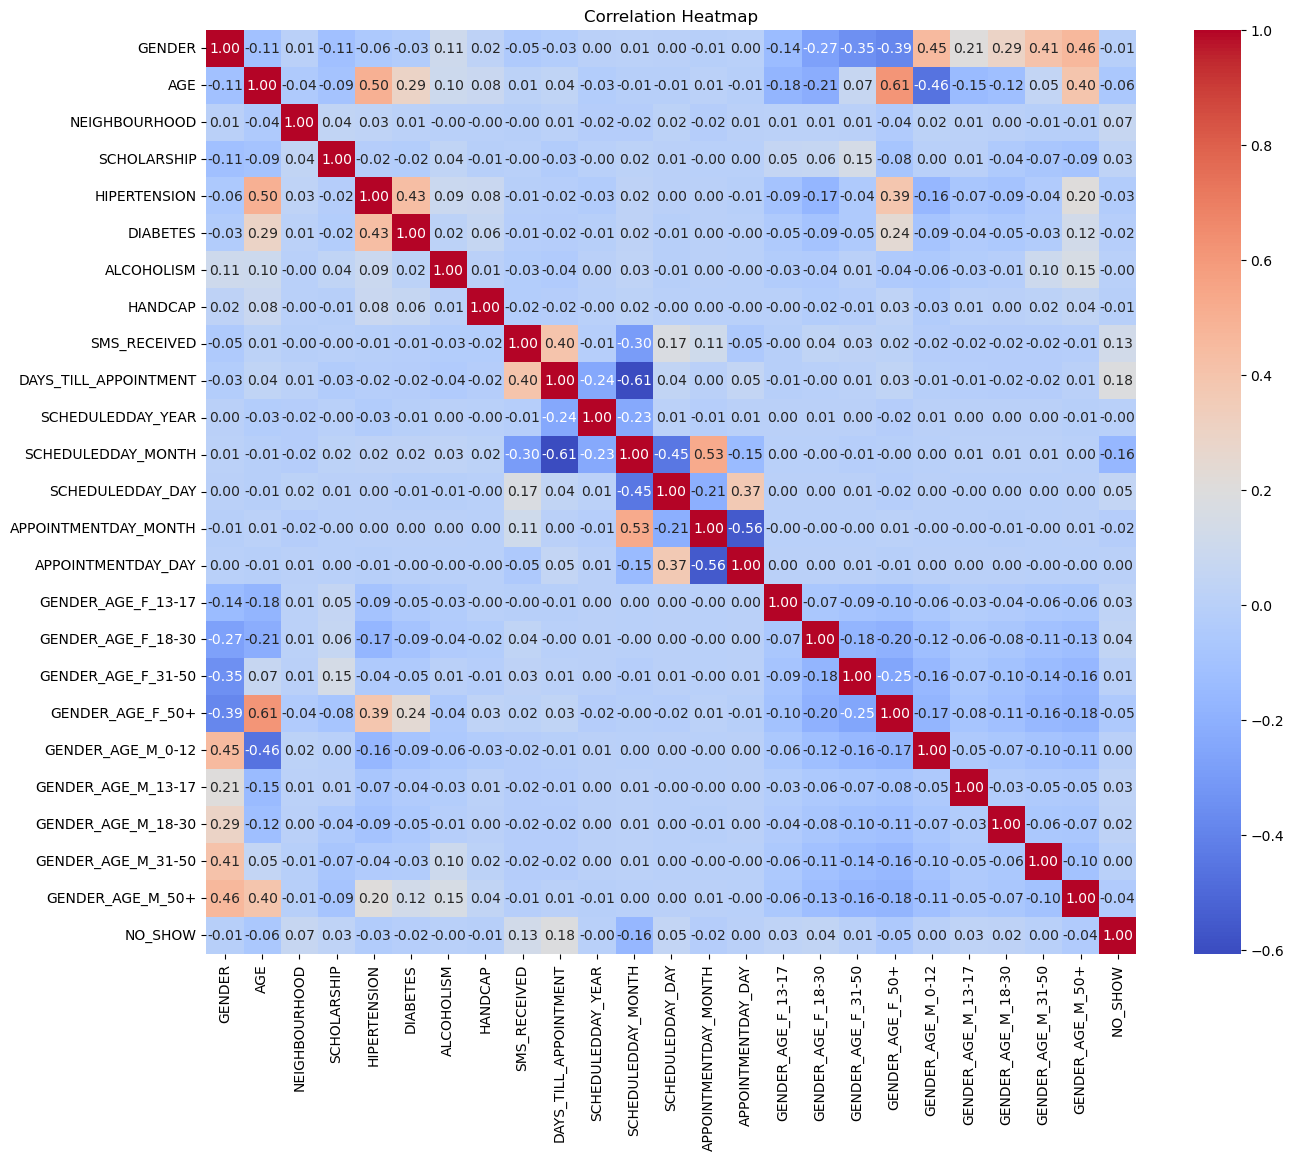

In [ ]:
# Calculate the correlation matrix for the training data
corr_matrix = train_data.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

**Observation**

There doesn't appear to be any multicollinearity (very high correlation like > 0.8 or < -0.8) among the variables.

### Tackle Class Imbalance of No-Show
Class imbalance can significantly impact the performance of machine learning models. We will first check if there's an imbalance between the two classes in the target variable *NO_SHOW*. Then, to address this, we will employ three different sampling techniques:
1. Upsampling (Oversampling)
2. Downsampling (Undersampling)
3. Synthetic Minority Over-sampling Technique (SMOTE)

We only resample the training set. The test set should remain untouched to serve as an unbiased evaluation metric for the model. Resampling only the training set ensures that the model generalizes well to new, unseen data. 

Before we proceed, let's first check the distribution of the target variable in the training set.

In [ ]:
# Calculate the actual counts of the 'NO_SHOW' column
no_show_counts = train_data['NO_SHOW'].value_counts().reset_index()
no_show_counts.columns = ['NO_SHOW', 'COUNT']

# Calculate the distribution of the 'NO_SHOW' column in percentages (rounded to 1 decimal place)
no_show_percentage = (train_data['NO_SHOW'].value_counts(normalize=True) * 100).round(1).reset_index()
no_show_percentage.columns = ['NO_SHOW', 'PERCENTAGE']

# Merge the counts and percentages into a single DataFrame
no_show_distribution = pd.merge(no_show_counts, no_show_percentage, on='NO_SHOW')

# Display the distribution in a table
print(no_show_distribution)

   NO_SHOW  COUNT  PERCENTAGE
0        0  70565        79.8
1        1  17851        20.2


#### Upsampling
Upsampling involves randomly duplicating observations from the minority class to balance the dataset.

In [ ]:
# Separate majority and minority classes in the original training set
train_majority = train_data[train_data.NO_SHOW == 0]
train_minority = train_data[train_data.NO_SHOW == 1]

# Upsample minority class
train_minority_upsampled = resample(train_minority, 
                                    replace=True,     # sample with replacement
                                    n_samples=len(train_majority),    # to match majority class
                                    random_state=123) # reproducible results

# Combine majority class with upsampled minority class
train_upsampled = pd.concat([train_majority, train_minority_upsampled]).reset_index(drop=True)

#### Downsampling
Downsampling involves randomly removing observations from the majority class to balance the dataset.

In [ ]:
# Downsample majority class
train_majority_downsampled = resample(train_majority, 
                                      replace=False,    # sample without replacement
                                      n_samples=len(train_minority),  # to match minority class
                                      random_state=123) # reproducible results

# Combine minority class with downsampled majority class
train_downsampled = pd.concat([train_majority_downsampled, train_minority]).reset_index(drop=True)

#### SMOTE
SMOTE creates synthetic samples from the minority class by interpolating between existing observations, enhancing diversity and aiding in balancing the dataset.

In [ ]:
# Separate features and target variable from original training data
X_train = train_data.drop('NO_SHOW', axis=1)
y_train = train_data['NO_SHOW']

# Initialize SMOTE object
smote = SMOTE(random_state=42)

# Fit SMOTE and obtain a balanced dataset
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Combine the resampled features and labels into a single DataFrame
train_smote = pd.concat([pd.DataFrame(X_train_smote), pd.DataFrame(y_train_smote, columns=['NO_SHOW'])], axis=1)

Let's check out the distribution of all available sampling datasets to confirm our operations.

In [ ]:
print("Class distribution in upsampled data:", train_upsampled['NO_SHOW'].value_counts())
print("\nClass distribution in downsampled data:", train_downsampled['NO_SHOW'].value_counts())
print("\nClass distribution in SMOTE data:", train_smote['NO_SHOW'].value_counts())

Class distribution in upsampled data: NO_SHOW
0    70565
1    70565
Name: count, dtype: int64

Class distribution in downsampled data: NO_SHOW
0    17851
1    17851
Name: count, dtype: int64

Class distribution in SMOTE data: NO_SHOW
1    70565
0    70565
Name: count, dtype: int64


All three sampling techniques have successfully balanced the class distribution in our training data. Now each class has an equal number of instances.

### Feature Scaling
In this section, we will perform feature scaling to standardize the range of our independent variables. Scaling is crucial for algorithms that use distance-based metrics.

#### Apply StandardScaler
We will use Standard Scaling to transform the data into a distribution with a mean of 0 and a standard deviation of 1.

In [ ]:
# Initialize the scaler
scaler = StandardScaler()

# List of feature columns to scale
feature_cols = train_data.columns.difference(['NO_SHOW'])

In [ ]:
# Create copies of the original data
train_data_scaled = train_data.copy()
test_data_scaled = test_data.copy()

# Apply scaling to the feature columns in the training and test sets
train_data_scaled[feature_cols] = scaler.fit_transform(train_data[feature_cols])
test_data_scaled[feature_cols] = scaler.transform(test_data[feature_cols])

In [ ]:
# Create copies of the resampled data
train_upsampled_scaled = train_upsampled.copy()
train_downsampled_scaled = train_downsampled.copy()
train_smote_scaled = train_smote.copy()

# Apply scaling to the feature columns in the resampled datasets
train_upsampled_scaled[feature_cols] = scaler.transform(train_upsampled[feature_cols])
train_downsampled_scaled[feature_cols] = scaler.transform(train_downsampled[feature_cols])
train_smote_scaled[feature_cols] = scaler.transform(train_smote[feature_cols])

Check if we have implemented Standard Scaling correctly.

In [ ]:
# Define a function to check if the mean is close to 0 and the standard deviation is close to 1
def check_scaling(df, cols_to_scale):
    return all(np.isclose(df[col].mean(), 0, atol=2e-1) and np.isclose(df[col].std(), 1, atol=2e-1) for col in cols_to_scale)

# List of feature columns to scale
feature_cols = train_data.columns.difference(['NO_SHOW'])

# Perform the sanity check on all datasets
print("Sanity check for original scaled training set:", check_scaling(train_data_scaled, feature_cols))
print("Sanity check for scaled test set:", check_scaling(test_data_scaled, feature_cols))
print("Sanity check for scaled upsampled set:", check_scaling(train_upsampled_scaled, feature_cols))
print("Sanity check for scaled downsampled set:", check_scaling(train_downsampled_scaled, feature_cols))
print("Sanity check for scaled SMOTE set:", check_scaling(train_smote_scaled, feature_cols))

Sanity check for original scaled training set: True
Sanity check for scaled test set: True
Sanity check for scaled upsampled set: True
Sanity check for scaled downsampled set: True
Sanity check for scaled SMOTE set: True


### Feature Selection
In this section, we will perform feature selection to identify the most important features for our model. Feature selection is crucial for making the model simpler, faster, and more interpretable.

To further refine our feature selection, we will use machine learning models to compute the feature importance. We will use Logistic Regression and Decision Trees for this purpose. This step will help us understand which features are most influential in predicting the target variable, *NO_SHOW*.

#### Logistic Regression Coefficient
We will look at the coefficients of the logistic regression model to understand the impact of each feature on the target variable.

We will focus on features that have at least 1% importance in either of the models.

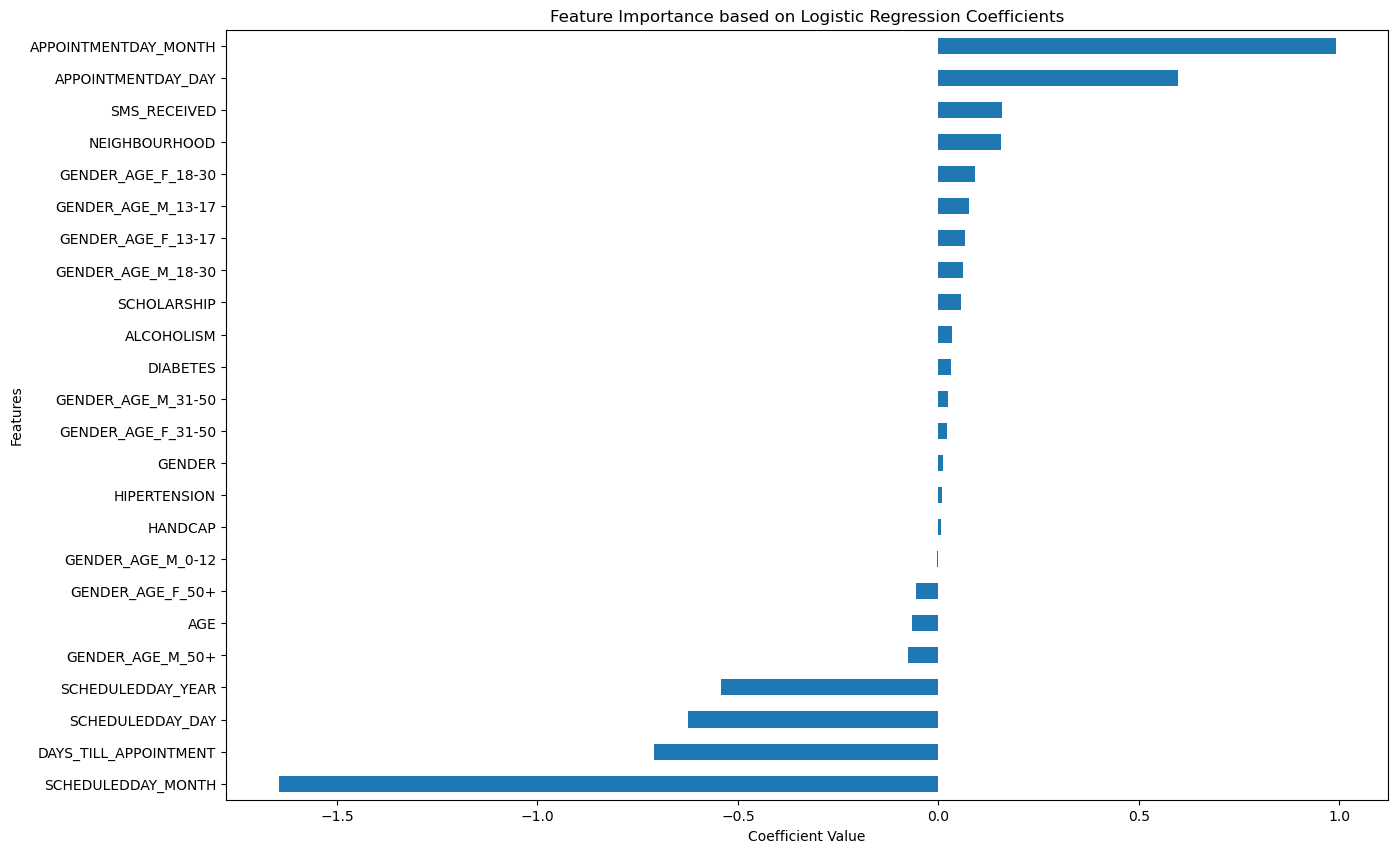

Important features based on Logistic Regression:
                       Coefficient
GENDER                    0.011936
AGE                      -0.065550
NEIGHBOURHOOD             0.155877
SCHOLARSHIP               0.055329
DIABETES                  0.032519
ALCOHOLISM                0.034749
SMS_RECEIVED              0.159255
DAYS_TILL_APPOINTMENT    -0.709013
SCHEDULEDDAY_YEAR        -0.542614
SCHEDULEDDAY_MONTH       -1.645038
SCHEDULEDDAY_DAY         -0.625329
APPOINTMENTDAY_MONTH      0.990447
APPOINTMENTDAY_DAY        0.597578
GENDER_AGE_F_13-17        0.065544
GENDER_AGE_F_18-30        0.091443
GENDER_AGE_F_31-50        0.021896
GENDER_AGE_F_50+         -0.055579
GENDER_AGE_M_13-17        0.075335
GENDER_AGE_M_18-30        0.062579
GENDER_AGE_M_31-50        0.023108
GENDER_AGE_M_50+         -0.077040
Number of important features in Logistic Regression: 21


In [ ]:
# Initialize the Logistic Regression model
logistic_model = LogisticRegression(class_weight='balanced', random_state=42)

# Fit the model on the scaled training data
logistic_model.fit(train_data_scaled.drop('NO_SHOW', axis=1), train_data_scaled['NO_SHOW'])

# Get the coefficients from the trained model
logistic_coef = pd.DataFrame(logistic_model.coef_.reshape(-1, 1), index=train_data_scaled.drop('NO_SHOW', axis=1).columns, columns=['Coefficient'])

# Plotting the feature importance
plt.figure(figsize=(15, 10))
logistic_coef['Coefficient'].sort_values().plot(kind='barh')
plt.title('Feature Importance based on Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()

# Filter features with at least 1% importance (0.01)
important_features_logistic = logistic_coef[abs(logistic_coef['Coefficient']) >= 0.01]

# Display the important features and their count
print("Important features based on Logistic Regression:")
print(important_features_logistic)
print(f"Number of important features in Logistic Regression: {len(important_features_logistic)}")

#### Decision Tree Feature Importance
We will use a Decision Tree model to get the feature importance scores.

We will focus on features that have at least 1% importance in either of the models.

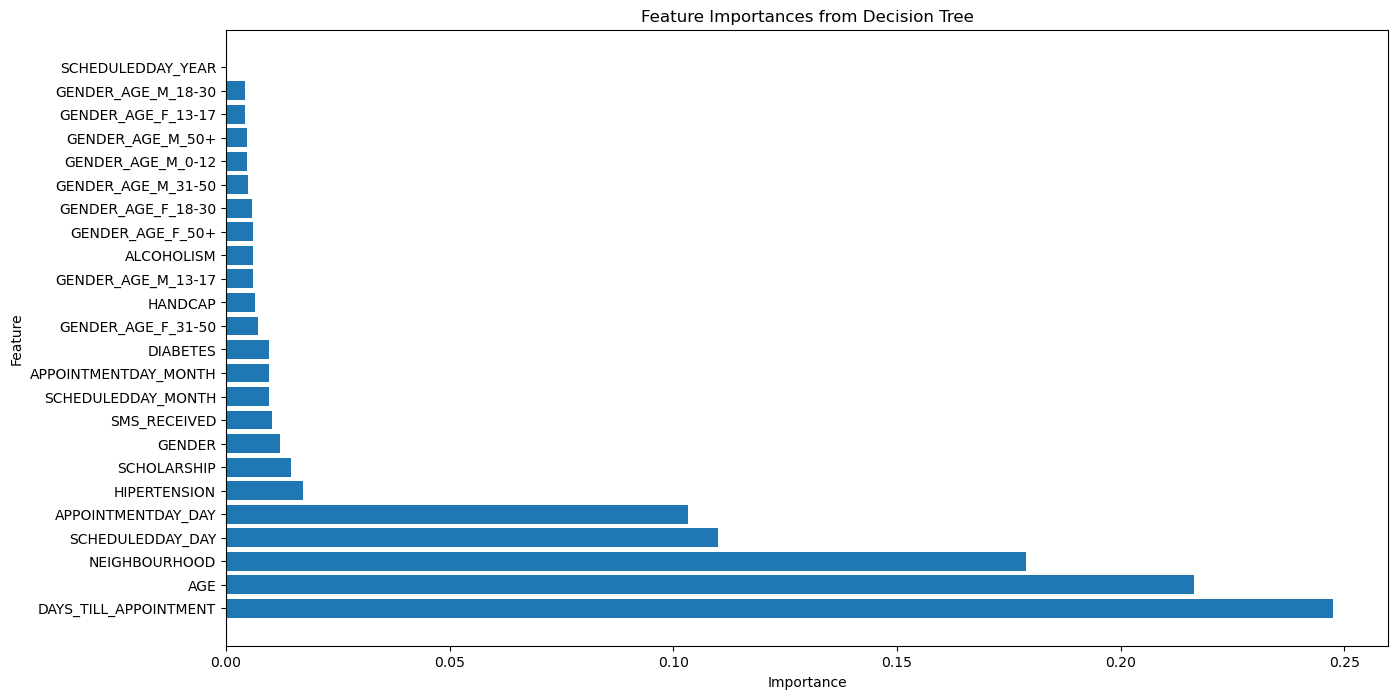

Important features based on Decision Tree:
                  Feature  Importance
9   DAYS_TILL_APPOINTMENT    0.247471
1                     AGE    0.216293
2           NEIGHBOURHOOD    0.178895
12       SCHEDULEDDAY_DAY    0.110084
14     APPOINTMENTDAY_DAY    0.103335
4            HIPERTENSION    0.017232
3             SCHOLARSHIP    0.014617
0                  GENDER    0.012101
8            SMS_RECEIVED    0.010206
Number of important features in Decision Tree: 9


In [ ]:
# Initialize the Decision Tree model
decision_tree_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Fit the model on the training data
decision_tree_model.fit(train_data.drop('NO_SHOW', axis=1), train_data['NO_SHOW'])

# Get the feature importances
feature_importances = decision_tree_model.feature_importances_

# Create a DataFrame for the feature importances
feature_importances_df = pd.DataFrame({'Feature': train_data.drop('NO_SHOW', axis=1).columns, 'Importance': feature_importances})

# Sort the DataFrame by the importances
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# Filter features with at least 1% importance
important_features_tree = feature_importances_df[feature_importances_df['Importance'] >= 0.01]

# Plotting all feature importances
plt.figure(figsize=(15, 8))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Decision Tree')
plt.show()

print("Important features based on Decision Tree:")
print(important_features_tree)
print(f"Number of important features in Decision Tree: {len(important_features_tree)}")

#### Combine important features from linear and tree-based models
We will combine the important features based on the union of one linear (logistic regression) and one tree based (decision tree) model.

In [ ]:
# Convert the important features to lists
important_features_logistic_list = important_features_logistic.index.values.tolist()
important_features_tree_list = important_features_tree['Feature'].values.tolist()

# Find the intersection of both lists
combined_important_features_union = list(set(important_features_logistic_list) | 
                                                set(important_features_tree_list))

print("Combined important features (Union):")
display(combined_important_features_union)
print(f"Total number of combined important features (Intersection): {len(combined_important_features_union)}")

Combined important features (Union):


['GENDER_AGE_F_18-30',
 'SCHEDULEDDAY_YEAR',
 'SMS_RECEIVED',
 'NEIGHBOURHOOD',
 'GENDER_AGE_F_31-50',
 'ALCOHOLISM',
 'GENDER',
 'DIABETES',
 'GENDER_AGE_F_13-17',
 'GENDER_AGE_M_31-50',
 'SCHEDULEDDAY_MONTH',
 'SCHOLARSHIP',
 'SCHEDULEDDAY_DAY',
 'HIPERTENSION',
 'GENDER_AGE_M_18-30',
 'APPOINTMENTDAY_MONTH',
 'GENDER_AGE_F_50+',
 'APPOINTMENTDAY_DAY',
 'GENDER_AGE_M_50+',
 'GENDER_AGE_M_13-17',
 'AGE',
 'DAYS_TILL_APPOINTMENT']

Total number of combined important features (Intersection): 22


In [ ]:
# Add 'NO_SHOW' to the list of important features
combined_important_features_union.append('NO_SHOW')

print(f"Total number of combined important features (Union) with target: {len(combined_important_features_union)}")

Total number of combined important features (Union) with target: 23


#### Filter data sets with combined important features 
We will filter all our available datasets with the combined important features and target.

In [ ]:
# Filter the original training and test sets
train_data_filtered = train_data[combined_important_features_union]
test_data_filtered = test_data[combined_important_features_union]

# Filter the scaled training and test sets
train_data_scaled_filtered = train_data_scaled[combined_important_features_union]
test_data_scaled_filtered = test_data_scaled[combined_important_features_union]

# Filter the upsampled, downsampled, and SMOTE sets
train_upsampled_filtered = train_upsampled[combined_important_features_union]
train_downsampled_filtered = train_downsampled[combined_important_features_union]
train_smote_filtered = train_smote[combined_important_features_union]

# Filter the scaled and upsampled, downsampled, and SMOTE sets
train_upsampled_scaled_filtered = train_upsampled_scaled[combined_important_features_union]
train_downsampled_scaled_filtered = train_downsampled_scaled[combined_important_features_union]
train_smote_scaled_filtered = train_smote_scaled[combined_important_features_union]

## Modeling

### Dataset Preperation
We will prepare the datasets that will be used for training and testing the models.

In [ ]:
# Original training sets
X_train = train_data_filtered.drop('NO_SHOW', axis=1)
y_train = train_data_filtered['NO_SHOW']

# Original test sets
X_test = test_data_filtered.drop('NO_SHOW', axis=1)
y_test = test_data_filtered['NO_SHOW']

# Scaled training and test sets
X_train_scaled = train_data_scaled_filtered.drop('NO_SHOW', axis=1)
X_test_scaled = test_data_scaled_filtered.drop('NO_SHOW', axis=1)

In [ ]:
# Upsampled set
X_train_upsampled = train_upsampled_filtered.drop('NO_SHOW', axis=1)
y_train_upsampled = train_upsampled_filtered['NO_SHOW']

# Downsampled set
X_train_downsampled = train_downsampled_filtered.drop('NO_SHOW', axis=1)
y_train_downsampled = train_downsampled_filtered['NO_SHOW']

# SMOTE set
X_train_smote = train_smote_filtered.drop('NO_SHOW', axis=1)
y_train_smote = train_smote_filtered['NO_SHOW']

# Scaled and upsampled set
X_train_upsampled_scaled = train_upsampled_scaled_filtered.drop('NO_SHOW', axis=1)

# Scaled and downsampled set
X_train_downsampled_scaled = train_downsampled_scaled_filtered.drop('NO_SHOW', axis=1)

# Scaled and SMOTE set
X_train_smote_scaled = train_smote_scaled_filtered.drop('NO_SHOW', axis=1)

### Model Selection
We will train multiple machine learning models (Logistic Regression, Decision Tree, Random Forest, and XGBoost) with Stratified K-Fold cross-validation on the original dataset to identify the one that performs best based on the ROC AUC.

In [ ]:
# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize models
logistic_model = LogisticRegression(class_weight='balanced', random_state=42)
decision_tree_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
random_forest_model = RandomForestClassifier(class_weight='balanced', random_state=42)
xgb_model = XGBClassifier(scale_pos_weight=(0.798 / 0.202), random_state=42)

# Perform cross-validation for each model
models = {'Logistic Regression': logistic_model, 
          'Decision Tree': decision_tree_model, 
          'Random Forest': random_forest_model, 
          'XGBoost': xgb_model}

for name, model in models.items():
    if name == 'Logistic Regression':
        score = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='roc_auc', n_jobs=-1).mean()
    else:
        score = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1).mean()
    
    print(f"Results for {name}:")
    print(f"ROC AUC: {score}")
    print("------")

Results for Logistic Regression:
ROC AUC: 0.6741735834786114
------
Results for Decision Tree:
ROC AUC: 0.5837592031580411
------
Results for Random Forest:
ROC AUC: 0.7198817856456108
------
Results for XGBoost:
ROC AUC: 0.7340418618844207
------


XGBoost is the best performing model with highest ROC AUC trained on the original dataset.

### Dataset selection
We will fit the best model (XGBoost) on priginal data set as well as different resampled data sets, and evaluate on the test set. This is to see how the model performs on different versions of the dataset. It will help us identify which resampling technique (if any) improves the model's performance on the test set.

In [ ]:
# Initialize the XGBoost model for original dataset
xgb_model_original = XGBClassifier(scale_pos_weight=(0.798 / 0.202), random_state=42)

# Initialize the XGBoost model for resampled datasets
xgb_model_resampled = XGBClassifier(random_state=42)

# Datasets
datasets = {
    'Original': (X_train, y_train),
    'Upsampled': (X_train_upsampled, y_train_upsampled),
    'Downsampled': (X_train_downsampled, y_train_downsampled),
    'SMOTE': (X_train_smote, y_train_smote)
}

# To store results
results = {}

# Loop through each dataset
for name, (X, y) in datasets.items():
    if name == 'Original':
        model = xgb_model_original
    else:
        model = xgb_model_resampled
    
    # Fit the model
    model.fit(X, y)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class
    
    # Evaluate the model
    roc_auc = roc_auc_score(y_test, y_pred_prob)  # Use probabilities for ROC AUC
    f1 = f1_score(y_test, y_pred)
    
    results[name] = {'ROC AUC': roc_auc, 'F1 Score': f1}

# Display the results
for name, metrics in results.items():
    print(f"Results for {name}:")
    print(f"ROC AUC: {metrics['ROC AUC']}")
    print(f"F1 Score: {metrics['F1 Score']}")
    print("------")

Results for Original:
ROC AUC: 0.7309831548230024
F1 Score: 0.4418541610192464
------
Results for Upsampled:
ROC AUC: 0.7278169637399273
F1 Score: 0.43795318002900346
------
Results for Downsampled:
ROC AUC: 0.7259312502656019
F1 Score: 0.44032037507325655
------
Results for SMOTE:
ROC AUC: 0.7147412387428275
F1 Score: 0.3633907463694698
------


Based on the results, the XGBoost model trained on the original dataset and evaluated on test set performs slightly better in terms of both ROC AUC and F1 Score compared to the models trained on the resampled datasets.

### Revisit Feature Importance
After we've selected the best model and dataset combination. We can revisit feature importance to help understand which features are driving the model's decisions and possibly simplify the model by removing less important features.

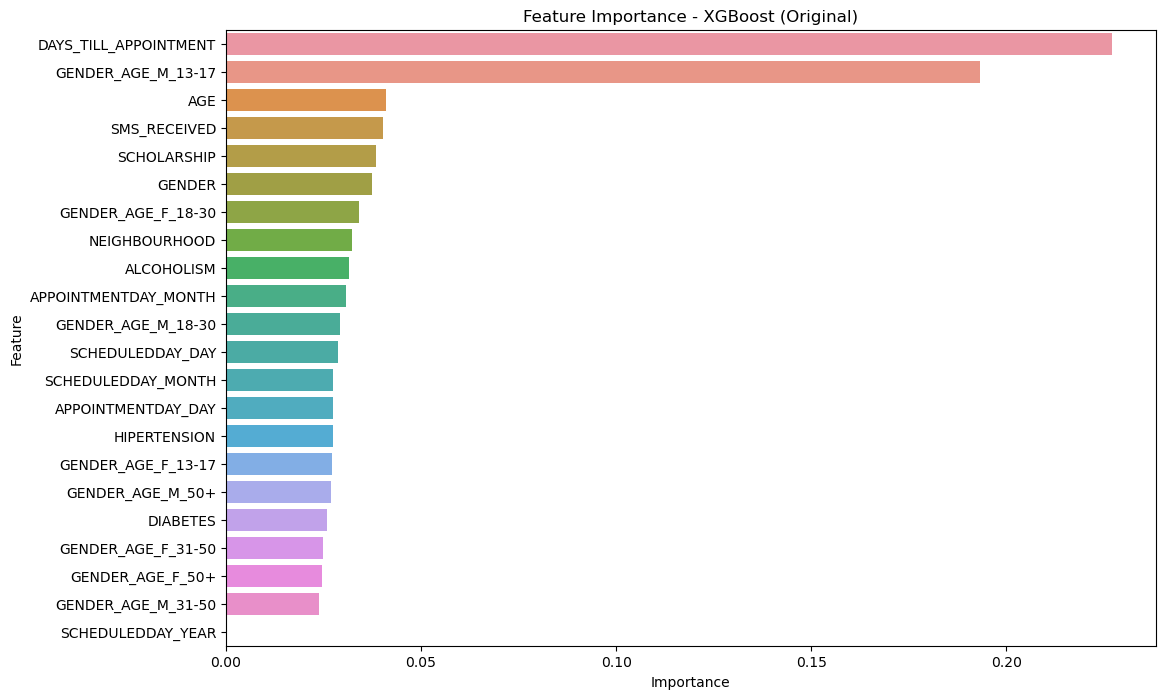

In [ ]:
# Retrain the model on the Upsampled dataset
xgb_model_original = XGBClassifier(scale_pos_weight=(0.798 / 0.202), random_state=42)
xgb_model_original.fit(X_train, y_train)

# Extract feature importances from the trained XGBoost model
feature_importances = xgb_model_original.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by the importances
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance - XGBoost (Original)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
# Filter features with at least 1% importance
important_features_revisited = feature_importance_df[feature_importance_df['Importance'] >= 0.01]

print("Important features based on XGBoost (Original):")
print(important_features_revisited)
print(f"Number of important features: {len(important_features_revisited)}")

Important features based on XGBoost (Original):
                  Feature  Importance
2   DAYS_TILL_APPOINTMENT    0.226964
17     GENDER_AGE_M_13-17    0.193218
10                    AGE    0.041116
8            SMS_RECEIVED    0.040272
1             SCHOLARSHIP    0.038433
13                 GENDER    0.037499
21     GENDER_AGE_F_18-30    0.034069
16          NEIGHBOURHOOD    0.032395
6              ALCOHOLISM    0.031652
5    APPOINTMENTDAY_MONTH    0.030705
7      GENDER_AGE_M_18-30    0.029308
9        SCHEDULEDDAY_DAY    0.028611
15     SCHEDULEDDAY_MONTH    0.027539
11     APPOINTMENTDAY_DAY    0.027454
0            HIPERTENSION    0.027410
12     GENDER_AGE_F_13-17    0.027300
3        GENDER_AGE_M_50+    0.026875
14               DIABETES    0.025799
20     GENDER_AGE_F_31-50    0.024842
4        GENDER_AGE_F_50+    0.024632
19     GENDER_AGE_M_31-50    0.023909
Number of important features: 21


In [ ]:
# Filter the training and test sets to include only the new set of important features
new_important_features = important_features_revisited['Feature'].tolist()
X_train_filtered = X_train[new_important_features]
X_test_filtered = X_test[new_important_features]

# Refit the XGBoost model on the filtered downsampled training set
xgb_model_original = XGBClassifier(scale_pos_weight=(0.798 / 0.202), random_state=42)
xgb_model_original.fit(X_train_filtered, y_train)

# Make prediction on the test set
y_pred_refit = xgb_model_original.predict(X_test_filtered)
y_pred_prob_refit = xgb_model_original.predict_proba(X_test_filtered)[:, 1]

# Evaluate the refitted model on the test set
roc_auc_refit = roc_auc_score(y_test, y_pred_prob_refit)
f1_score_refit = f1_score(y_test, y_pred_refit)
print(f"Results for XGBoost (Original) with New Important Features:")
print(f"ROC AUC: {roc_auc_refit}")
print(f"F1 Score: {f1_score_refit}")

Results for XGBoost (Original) with New Important Features:
ROC AUC: 0.730970797109123
F1 Score: 0.4418541610192464


With the same threshold of 0.01, we have further reduced feature space to 21 important features , without losing the model's predictive power.

#### Save reduced input features
We will save the new features without target into pickle. This allows us to easily reuse them in future runs of our analysis or in deployment scenarios, ensuring consistency and reproducibility.

In [ ]:
# Save the new important features to a pickle file
with open('./data/features/X_train_important_features.pkl', 'wb') as f:
    pickle.dump(new_important_features, f)

### Hyperparameter Tuning
We will fine-tune the hyperparameters of the selected model using [Hyperopt](https://hyperopt.github.io/hyperopt/#algorithms). The objective is to maximize the ROC AUC score. Hyperopt employs Bayesian optimization to find the best hyperparameters more efficiently than grid search or random search.

Here's a general outline of the steps we will follow:
1. Define the Objective Function: This function will take in hyperparameters, train the Gradient Boosting model, and return the metric we want to optimize (in this case, ROC AUC).
2. Define the Hyperparameter Space: Specify the range of values for each hyperparameter we want to tune.
    - **`n_estimators`**: The number of boosting rounds or trees to build. It's important to tune it properly as a very large number would make the model overfit. Range: [50, 1000].
    - **`max_depth`**: The maximum depth of the individual estimators. The depth of the tree can be used to control over-fitting. Range: [3, 14].
    - **`learning_rate`**: Step size shrinkage used to prevent overfitting. Range is [0.01, 0.2].
    - **`gamma`**: Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be. Range: [0, 0.5].
    - **`colsample_bytree`**: The fraction of features to choose for each boosting round. Used for subsampling of columns. Range: [0.3, 1].
    - **`subsample`**: The fraction of samples to be used for each boosting round. Range: [0.6, 1].
    - **`min_child_weight`**: Minimum sum of instance weight (hessian) needed in a child. Used to control over-fitting. Range: [1, 10].
3. Run Optimization: Use Hyperopt to run the optimization process.

In [ ]:
# Load the important features from the pickle file
with open('./data/features/X_train_important_features.pkl', 'rb') as f:
    important_features = pickle.load(f)

# Filter the original X_train and X_test dataset to include only the important features
X_train_filtered = X_train[important_features]
X_test_filtered = X_test[important_features]

In [ ]:
best_score = 0  # Initialize the best score
iteration = 0  # Initialize the iteration counter

# Define the objective function
def objective(params):
    global best_score  # Declare best_score as global to update it
    global iteration  # Declare iteration as global to update it
    iteration += 1  # Increment the iteration counter
    
    clf = XGBClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        gamma=params['gamma'],
        colsample_bytree=params['colsample_bytree'],
        subsample=params['subsample'],
        min_child_weight=int(params['min_child_weight']),
        scale_pos_weight=(0.798 / 0.202),
        random_state=42
    )
    
    # Stratified K-Fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(clf, X_train_filtered, y_train, cv=skf, scoring='roc_auc', n_jobs=-1).mean()
    
    if score > best_score:
        best_score = score
        print(f"New best score at iteration {iteration}: {best_score}")
        display("Best parameters so far:", params)
    
    return {'loss': -score, 'status': STATUS_OK}

# Define the parameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 1),
    'max_depth': hp.quniform('max_depth', 3, 14, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1),
    'subsample': hp.uniform('subsample', 0.6, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1)
}

# Initialize a trials object
trials = Trials()

# Run the hyperparameter optimization
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

New best score at iteration 1: 0.722214800953944       
  0%|          | 0/100 [00:49<?, ?trial/s, best loss=?]

'Best parameters so far:'

{'colsample_bytree': 0.4953015843404557,
 'gamma': 0.3385215218911597,
 'learning_rate': 0.09638565283756789,
 'max_depth': 14.0,
 'min_child_weight': 4.0,
 'n_estimators': 960.0,
 'subsample': 0.923417718661481}

New best score at iteration 3: 0.7381147711814111                                  
  2%|▏         | 2/100 [01:45<1:20:14, 49.13s/trial, best loss: -0.722214800953944]

'Best parameters so far:'

{'colsample_bytree': 0.5257403916523757,
 'gamma': 0.3985583035628915,
 'learning_rate': 0.18945660122116278,
 'max_depth': 4.0,
 'min_child_weight': 1.0,
 'n_estimators': 206.0,
 'subsample': 0.9667863486397964}

New best score at iteration 16: 0.7383351872295797                                 
 15%|█▌        | 15/100 [06:27<32:16, 22.78s/trial, best loss: -0.7381147711814111]

'Best parameters so far:'

{'colsample_bytree': 0.8823170237569635,
 'gamma': 0.28131635485944534,
 'learning_rate': 0.1277002467681471,
 'max_depth': 4.0,
 'min_child_weight': 7.0,
 'n_estimators': 179.0,
 'subsample': 0.9761632407220616}

New best score at iteration 18: 0.740819290147685                                  
 17%|█▋        | 17/100 [07:39<36:09, 26.13s/trial, best loss: -0.7383351872295797]

'Best parameters so far:'

{'colsample_bytree': 0.6147887860914087,
 'gamma': 0.3014514575014713,
 'learning_rate': 0.024912762377601757,
 'max_depth': 5.0,
 'min_child_weight': 6.0,
 'n_estimators': 829.0,
 'subsample': 0.9172078802418366}

New best score at iteration 22: 0.7415136626609111                                 
 21%|██        | 21/100 [09:06<27:44, 21.07s/trial, best loss: -0.740819290147685]

'Best parameters so far:'

{'colsample_bytree': 0.8113652045326214,
 'gamma': 0.45634301810784583,
 'learning_rate': 0.014615184424319277,
 'max_depth': 6.0,
 'min_child_weight': 5.0,
 'n_estimators': 672.0,
 'subsample': 0.7725334048746016}

New best score at iteration 23: 0.7425069970493705                                 
 22%|██▏       | 22/100 [09:36<29:52, 22.98s/trial, best loss: -0.7415136626609111]

'Best parameters so far:'

{'colsample_bytree': 0.8256168767037005,
 'gamma': 0.4974253309734911,
 'learning_rate': 0.01378566565251596,
 'max_depth': 7.0,
 'min_child_weight': 6.0,
 'n_estimators': 672.0,
 'subsample': 0.7832784160027706}

New best score at iteration 38: 0.743503641880195                                  
 37%|███▋      | 37/100 [18:22<36:50, 35.08s/trial, best loss: -0.7425069970493705]

'Best parameters so far:'

{'colsample_bytree': 0.5547103400612381,
 'gamma': 0.4565024075152735,
 'learning_rate': 0.01024371856856813,
 'max_depth': 11.0,
 'min_child_weight': 5.0,
 'n_estimators': 344.0,
 'subsample': 0.8528421424055362}

100%|██████████| 100/100 [50:18<00:00, 30.19s/trial, best loss: -0.743503641880195]


The best loss (which is actually the negative of the ROC AUC score, because Hyperopt minimizes the loss) is approximately 0.744. This suggests that hyperparameter tuning has led to a slight improvement in the model's performance as compared to the mean ROC AUC score we obtained before tuning of 0.734.

#### Save best hyperparameters
We will save the best hyperparameters to a pickle file, which can be loaded later for training the final model.

In [ ]:
# Best parameters obtained from hyperparameter tuning
best_params = {
    'n_estimators': int(344),  # Convert float to int
    'max_depth': int(11),  # Convert float to int
    'learning_rate': 0.01024371856856813,
    'gamma': 0.4565024075152735,
    'colsample_bytree': 0.5547103400612381,
    'subsample': 0.8528421424055362,
    'min_child_weight': int(5),  # Convert float to int
    'scale_pos_weight': 0.798 / 0.202,
    'random_state': 42
}

# Save the best hyperparameters to a pickle file
with open('./data/hyperparameters/XGBoost_hyperparameters.pkl', 'wb') as f:
    pickle.dump(best_params, f)
    
print("Best hyperparameters saved to './data/hyperparameters/XGBoost_hyperparameters.pkl'")

Best hyperparameters saved to './data/hyperparameters/XGBoost_hyperparameters.pkl'


### Train Final Model
After hyperparameter tuning and model selection, the final model chosen was a Gradient Boosting Classifier trained on downsampled data. The model's performance is also evaluated on the test data, and the results are as follows.

In [ ]:
# Load the best hyperparameters
with open('./data/hyperparameters/XGBoost_hyperparameters.pkl', 'rb') as f:
    best_params = pickle.load(f)

# Initialize the XGBoost model
xgb_model_final = XGBClassifier(**best_params)

# Fit the model on the filtered training set
xgb_model_final.fit(X_train_filtered, y_train)

# Make predictions on the test set
y_pred_final = xgb_model_final.predict(X_test_filtered)
y_pred_prob = xgb_model_final.predict_proba(X_test_filtered)[:, 1]

# Evaluate the model
roc_auc_final = roc_auc_score(y_test, y_pred_prob)
f1_score_final = f1_score(y_test, y_pred_final)

print(f"Final Model Evaluation:")
print(f"ROC AUC: {roc_auc_final}")
print(f"F1 Score: {f1_score_final}")

Final Model Evaluation:
ROC AUC: 0.7372062798117146
F1 Score: 0.4495375408052231


The ROC AUC score has improved from 0.7309 to 0.7372 while the F1 Score has also improved from 0.4418 to 0.4495. Although the improvement is not drastic, it's still a positive change that suggests the model is better at distinguishing between the positive and negative classes.

#### Save final model
We will save the final trained model to a pickle file. This will allow us to easily load the model later for making predictions or further analysis.

In [ ]:
# Save the trained model to a pickle file
with open("./model/xgb_model.pkl", "wb") as f:
    pickle.dump(xgb_model_final, f)

print("Model has been saved as './model/xgb_model.pkl'")

Model has been saved as './model/xgb_model.pkl'


### Final Model Evaluation
This section presents a thorough evaluation of our predictive model for forecasting patient no-shows at medical appointments. Key metrics and visualizations are used to assess accuracy and reliability:
- **Confusion Matrix**: Shows the model's correct and incorrect predictions, highlighting its effectiveness in classifying no-shows and shows.
- **Classification Report**: Provides precision, recall, and F1-score for each class, indicating the model's accuracy and balance in prediction.
- **ROC Curve**: Evaluates the model's ability to distinguish between no-show and show cases, as indicated by the Area Under the Curve (AUC).
- **Precision-Recall Curve**: Especially relevant for our imbalanced dataset, this curve illustrates the trade-off between precision and recall, reflected in the AUC-PR score.

In [ ]:
# Load the trained model from the pickle file
with open("./model/xgb_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

In [ ]:
# Make predictions on the test set using the loaded model
y_pred_final = loaded_model.predict(X_test_filtered)
y_pred_prob = loaded_model.predict_proba(X_test_filtered)[:, 1]

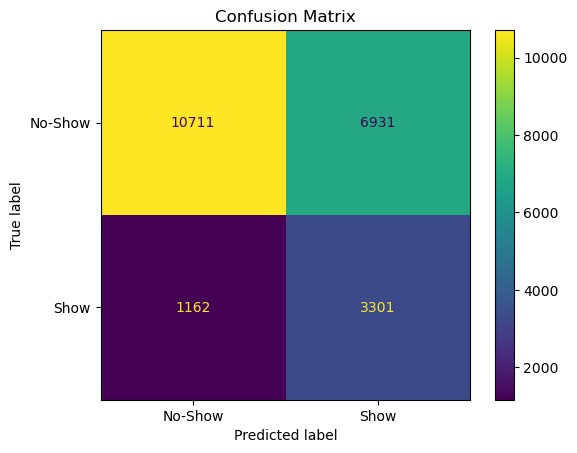

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_final)

# Display the confusion matrix
ConfusionMatrixDisplay(cm, display_labels=['No-Show', 'Show']).plot()
plt.title('Confusion Matrix')
plt.show()

Based on the confusion matrix above, with label "No-Show" is coded as 0 and "Show" is coded as 1, the matrix can be interpreted as follows:
- True Negative (TN): 10,711 - The number of actual "No-Show" cases that were correctly predicted as "No-Show".
- False Positive (FP): 6,931 - The number of actual "No-Show" cases that were incorrectly predicted as "Show".
- False Negative (FN): 1,162 - The number of actual "Show" cases that were incorrectly predicted as "No-Show".
- True Positive (TP): 3,301 - The number of actual "Show" cases that were correctly predicted as "Show".

In [ ]:
# Generate classification report
report = classification_report(y_test, y_pred_final, target_names=['No-Show', 'Show'])
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

     No-Show       0.90      0.61      0.73     17642
        Show       0.32      0.74      0.45      4463

    accuracy                           0.63     22105
   macro avg       0.61      0.67      0.59     22105
weighted avg       0.79      0.63      0.67     22105



The model has high precision but lower recall for the "No-Show" class, meaning it's good at correctly identifying "No-Shows" but misses a significant number of them. For the "Show" class, the model has high recall but low precision, meaning it identifies most of the "Shows" but also has a lot of false positives.

The F1-Score for "No-Show" is decent at 0.73, but it's lower for "Show" at 0.45, indicating room for improvement, especially in balancing precision and recall for the "Show" class.

Overall, the model has an accuracy of 0.63, which represents the ratio of correct predictions to the total number of instances.

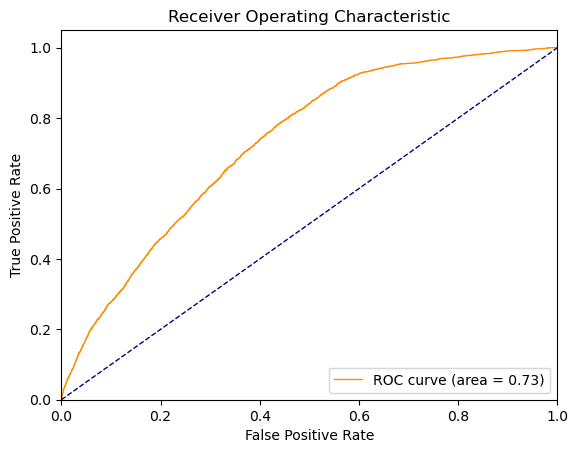

In [ ]:
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

The ROC curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings. The area under the curve (AUC) quantifies the overall ability of the model to discriminate between the positive and negative classes.

The model has an AUC of 0.73, which means it has moderate ability to distinguish between the positive and negative classes. The trade-off involved is that in order to achieve a high recall (True Positive Rate), the model will also yield a high False Positive Rate. 

Ideally, we want a model that has a high recall (it captures most of the positive instances) and a low Positive Rate(it doesn't flag many negative instances as positive). This would correspond to an AUC-ROC close to 1.

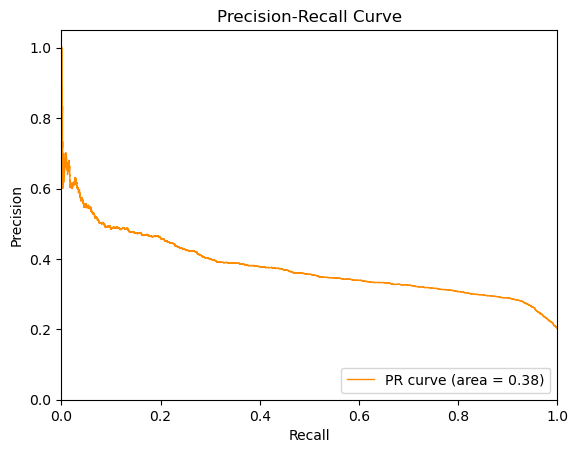

In [ ]:
# Compute the precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

# Compute the area under the precision-recall curve
pr_auc = auc(recall, precision)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=1, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.show()

The PR curve plots the trade-off between precision and recall at various threshold settings. In the context of imbalanced datasets, the AUC-PR can provide a more informative picture of model performance than AUC-ROC, especially when the positive class (minority class) is of greater interest. In an ideal scenario, we would want the AUC-PR to be closer to 1, which would mean that the model has high precision and high recall. 

The area under the Precision-Recall curve (AUC-PR) of 0.38 indicates that  that the model struggles to achieve a good balance between precision and recall. In another words, The model is quite good at identifying most of the actual no-shows (high recall), but it also incorrectly flags many patients who would have shown up as no-shows (lower precision).

## Areas for Improvement and Recommendations
Based on the evaluations above, below are some areas for improvement and recommendations:

### Areas for Improvement
1. **ROC AUC Score**: While our ROC AUC score of 0.73 indicates moderate ability to distinguish between the positive and negative classes, it could be improved for a more reliable model.

2. **F1 Score**: The F1 score is a balance between precision and recall, and our model's F1 score of 0.45 suggests that it could do better, especially for the minority class.

3. **Precision-Recall Curve (AUC-PR)**: An AUC-PR of 0.38 indicates that the model's performance in terms of both precision and recall for the minority class could be significantly improved.

4. **Classification Report**: The report shows that while the model has a high recall for the minority class, the precision is low. This suggests that the model is identifying too many false positives.

5. **Confusion Matrix**: The number of false positives and false negatives could be reduced for a more balanced model.

### Recommendations
1. **Enhanced Feature Engineering**: To further improve our model's ROC AUC, F1 score, and AUC-PR, we recommend adding two new features based on the patient's appointment history:
    - **Total Prior Appointments**: This feature tracks the total number of appointments a patient has had before the current appointment. It provides a broader context of the patient's engagement with healthcare services.
    - **Total Missed Appointments**: This feature counts the number of appointments the patient has missed in the past. It directly relates to the likelihood of future no-shows, as a pattern of missing appointments could indicate a higher probability of not showing up.
    
    
    By incorporating these historical data points, the model can better understand each patient's appointment attendance patterns, leading to more accurate predictions. These features have been shown to **significantly enhance** model performance in similar studies ([reference](https://www.linkedin.com/pulse/predict-medical-show-appointments-wael-dagash-/)), addressing the areas of ROC AUC, F1 score, and AUC-PR, which are crucial for a balanced and effective predictive model.

2. **Advanced Resampling Techniques**: Try more advanced resampling techniques like ADASYN or Borderline-SMOTE to balance the classes.

3. **Ensemble Methods**: Use ensemble methods like stacking or boosting with different base models to improve performance.

4. **Model Selection**: Explore other algorithms that are well-suited for imbalanced datasets, such as LightGBM or CatBoost.

5. **Threshold Tuning**: Adjust the classification threshold based on the precision-recall trade-off that is most suitable for our specific problem.

6. **Hyperparameter Tuning**: Revisit hyperparameter tuning with a broader or different range of parameters, especially after making other changes like feature engineering.